## Setup

In [1]:
import pandas as pd
import statistics as stats
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob
import numpy as np
from scipy.ndimage import gaussian_filter1d

/Users/candacechan/opt/miniconda3/envs/bioconda/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


KeyboardInterrupt: 

In [7]:
sns.set(rc={'figure.figsize':(5,5)})

In [8]:
def numsumfile_reader(filename):
    df = pd.read_csv(filename,sep="\t")
    bins=[int(i) for i in list(df.columns)][:-1]
    scores=list(df.iloc[0])[:-1]
    bin2score = dict(zip(bins, scores))
    return bin2score

def numsumfile_reader_minus(filename):
    df = pd.read_csv(filename,sep="\t")
    bins=[int(i) for i in list(df.columns)][:-1]
    scores=list(df.iloc[0])[:-1]
    scores = scores[::-1]
    bin2score = dict(zip(bins, scores))
    return bin2score

sigs = {("C","A"):"C>A", 
	   ("C","G"):"C>G", 
	   ("C","T"):"C>T", 
	   ("T","A"):"T>A", 
	   ("T","C"):"T>C", 
	   ("T","G"):"T>G",
	  }
sig_types=list(sigs.values())[:6]

equiv_sigs = {
    ("C","A"):("G","T"), 
    ("C","G"):("G","C"), 
    ("C","T"):("G","A"), 
    ("T","A"):("A","T"), 
    ("T","C"):("A","G"), 
    ("T","G"):("A","C")
	  }

### Needed to combine the substitutions that are the same. Take the mean of means?
sigs_str = {
    "G>T":"C>A",
    "G>C":"C>G",
    "G>A":"C>T", 
    "A>T":"T>A",
    "A>G":"T>C",
    "A>C":"T>G",   
}

subsD = {'C>A': '#c0024b', 'C>G': '#680efd', 'C>T': '#59b730', 'T>A': '#ee77ee', 'T>C': '#214e23', 'T>G': '#3ed7c9'}

# Plot All

cpg cpgIslandExt.hg38


Adjusted max nlm/ctrl = 1.1758312744855064


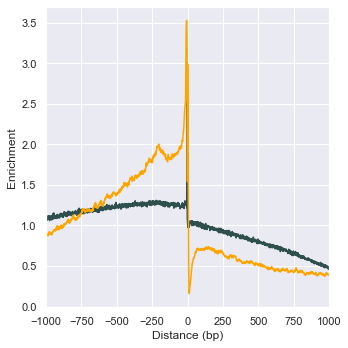

unibind hg38_compressed_TFBSs_unibind_robust
Adjusted max nlm/ctrl = 1.2788527903873779


KeyboardInterrupt: 

In [4]:
def read_file(filename): 
	df=pd.read_csv(filename, sep="\t")
	bins=[int(i) for i in list(df.columns)][:-1]
	scores=list(df.iloc[0])[:-1]
	mean_scores = sum(scores)/len(scores)
	enrich = [(i/mean_scores) for i in scores]
	return bins, enrich

def get_df(kmer, analysis, header): 
	fn = f"{analysis}/{header}.bed.score.mutations_{kmer}bp_nulls.bed.txt..list.out.num"
	bins, enrich = read_file(fn)
	## repeat for controls
	ctrl_fn = f"{analysis}/{header}.bed.score.mutations_{kmer}bp_nulls_controls_nulls.bed.txt..list.out.num"
	bins, ctrl_enrich = read_file(ctrl_fn)

	data=pd.DataFrame({"bins":bins, "scores":enrich, "ctrl_scores":ctrl_enrich})

	max_score = data.scores.max() ### maximum of nlms 
	max_ctrl = data.ctrl_scores.max() ### maximum of ctrls
	print(f"Adjusted max nlm/ctrl = {max_score/max_ctrl}")
	return data

def plot_all(all_df, analysis, kmer, color, xlim):
	
	ax = sns.lineplot(x = 'bins', y = 'ctrl_scores', 
					  data=all_df, 
					  color="darkslategray", errorbar=None)
	ax = sns.lineplot(x = 'bins', y = 'scores', 
					  data=all_df, 
					  color=color, errorbar=None)
	ax.set(xlabel='Distance (bp)', ylabel='Enrichment')

	plt.xlim(-xlim, xlim)
	plt.tight_layout()
	plt.show()
	plt.close()
	

analysis2header = {"cpg":"cpgIslandExt.hg38", 
 "unibind":"hg38_compressed_TFBSs_unibind_robust"}

analysis2color = {"cpg":"orange", 
 "unibind":"#2F83FA"}

analysis2xlim = {"cpg":1000, 
 "unibind":500}

analysis2title = {"cpg":"Cpg Island", "unibind":"UniBind"}

for kmer in [13]:
	for analysis, header in analysis2header.items():
		print(analysis, header)
		all_df = get_df(kmer, analysis, header)
		plot_all(all_df, analysis, kmer, analysis2color[analysis], analysis2xlim[analysis])

### Plot ALL in barplot

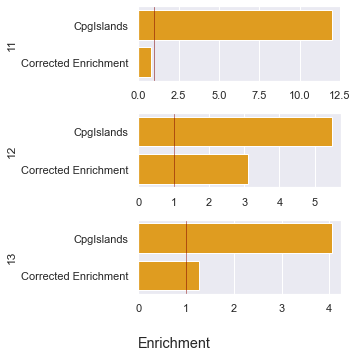

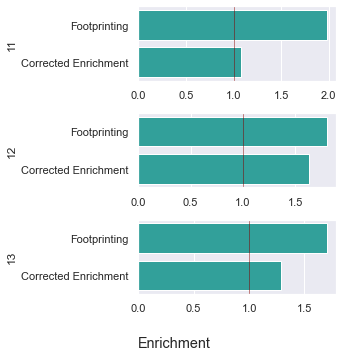

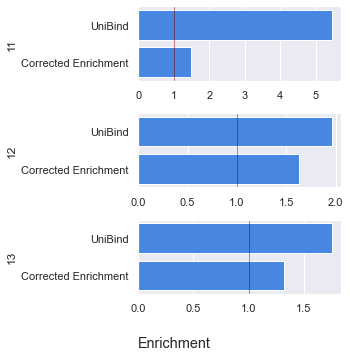

In [ ]:
analysis2header = {
'cpg': 'cpgIslandExt.hg38',
'fp': 'consensus_footprints_and_collapsed_motifs_hg38',
'unibind': 'hg38_compressed_TFBSs_unibind_robust'
}

analysis2title = {"cpg":"CpgIslands", "fp":"Footprinting", "unibind":"UniBind", "tfbs":"TFBS"}

analysis2color = {"cpg":"orange", 
 "fp":"lightseagreen", 
 "tfbs":"indigo",
 "unibind":"#2F83FA"}

muts = ["dels", "subs", "ins"]

for analysis, header in analysis2header.items():
    all_df = pd.DataFrame()

    for kmer in [11,12,13]:
        for mut in muts:
            filename = f"{analysis}/{header}.bed.score.mutations_{kmer}bp_nulls_{mut}.bed.txt..list.out.num"
            bins, enrich = read_file(filename) 
            ## Repeat for controls
            ctrl_fn = f"{analysis}/{header}.bed.score.mutations_{kmer}bp_nulls_controls_nulls_{mut}.bed.txt..list.out.num"
            bins, ctrl_enrich = read_file(ctrl_fn)

            data=pd.DataFrame({"bins":bins, "score":enrich, "ctrl":ctrl_enrich, "mut":mut,  "kmer":kmer})
            melted = pd.melt(data, id_vars=['bins', 'mut', 'kmer'], value_vars=['score', 'ctrl'])
            all_df = pd.concat([all_df, melted])

    combined_df = pd.DataFrame()
    for kmer in [11,12,13]:
        subdf = all_df[all_df.kmer == kmer]
        enrich = subdf[(subdf.variable == "score")]['value'].max()
        ctrl_enrich = subdf[(subdf.variable == "ctrl")]['value'].max()
        corr = enrich/ctrl_enrich
        df = pd.DataFrame([[enrich, corr]], columns=[analysis2title[analysis], f'Corrected Enrichment'])
        df['kmer']=kmer
        combined_df = pd.concat([combined_df, df])
    
    plot_df = pd.melt(combined_df, id_vars=['kmer'], value_vars=[analysis2title[analysis], f'Corrected Enrichment'])

    fig, ax = plt.subplots(nrows=3, sharex=False)
    for idx, kmer in enumerate([11,12,13]):
        g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
                        y="variable",
                        x="value",
                        color=analysis2color[analysis],
                        ax = ax[idx])
        g.set_ylabel(f"{kmer}")
        g.set_xlabel("")
        g.axvline(1, color="maroon", lw=0.5)
    fig.supxlabel("Enrichment")
    plt.tight_layout()
    plt.show()
    plt.close()

# Plot the ins, dels, subs

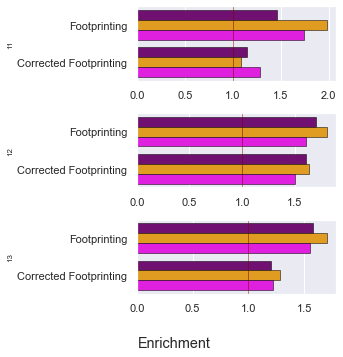

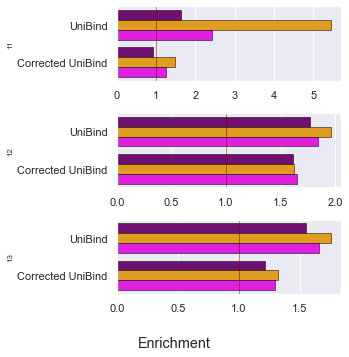

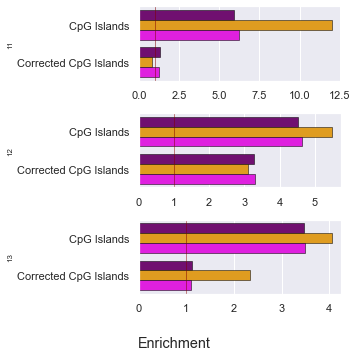

In [ ]:
muts = ["ins", "dels", "subs"]
analysis2title = {"cpg":"CpG Islands", "fp":"Footprinting", "unibind":"UniBind"}
analysis2header = {
 "fp":"consensus_footprints_and_collapsed_motifs_hg38", 
 "unibind":"hg38_compressed_TFBSs_unibind_robust",
"cpg":"cpgIslandExt.hg38"
}

for analysis, header in analysis2header.items():
    all_df = pd.DataFrame()
    for kmer in [11,12,13]:
        for mut in muts:
            filename = f"{analysis}/{header}.bed.score.mutations_{kmer}bp_nulls_{mut}.bed.txt..list.out.num"
            bins, enrich = read_file(filename)
            ## Repeat for controls
            ctrl_fn = f"{analysis}/{header}.bed.score.mutations_{kmer}bp_nulls_controls_nulls_{mut}.bed.txt..list.out.num"
            bins, ctrl_enrich = read_file(ctrl_fn)
            
            data=pd.DataFrame({"bins":bins, "Enrichment":enrich, "Mutation":mut, "Control":ctrl_enrich, "kmer":kmer})
            melted = pd.melt(data, id_vars=['bins', 'Mutation', 'kmer'], value_vars=['Enrichment', 'Control'])
            all_df = pd.concat([all_df, melted])

    combined_df = pd.DataFrame()
    for kmer in [11,12,13]:
        for mut in muts:
            subdf = all_df[(all_df.kmer == kmer) & (all_df.Mutation == mut)]
            real = subdf[(subdf.variable == "Enrichment")]['value'].max()
            ctrl = subdf[(subdf.variable == "Control")]['value'].max()
            corr = real/ctrl
            df = pd.DataFrame([[real, corr]], columns=[analysis2title[analysis], f'Corrected {analysis2title[analysis]}'])
            df['kmer']=kmer
            df['Mutation']=mut
            combined_df = pd.concat([combined_df, df])
            
    plot_df = pd.melt(combined_df, id_vars=['kmer','Mutation'], value_vars=[analysis2title[analysis], f'Corrected {analysis2title[analysis]}'])

    my_pal = {"ins":"purple", "dels":"orange", "subs":"magenta"}

    fig, axs = plt.subplots(nrows=3)
    for idx, kmer in enumerate([11,12,13]):
        g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
                        y="variable",
                        x="value",
                        hue="Mutation",
                        palette=my_pal, linewidth=0.5, edgecolor='black',
                        ax = axs[idx])
        g.set_ylabel(f"{kmer}", fontsize=8)
        g.set_xlabel("")
        g.legend_.remove()
        g.axvline(1, color='maroon', lw=0.5)
    fig.supxlabel("Enrichment")
    plt.tight_layout()
    plt.show()
    plt.close()

# Plot substitution subtypes

In [ ]:
def read_subs_file(filename): 
	df=pd.read_csv(filename, sep="\t")
	bins=[int(i) for i in list(df.columns)][:-1]
	scores=list(df.iloc[0])[:-1]
	return bins, scores

def get_subs_df(kmer, analysis, header, refsub, altsub):
    subs_fn1 = f"{analysis}/{header}.bed.score.mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.txt..list.out.num"
    equiv_sig = equiv_sigs[(refsub, altsub)]
    subs_fn2 = f"{analysis}/{header}.bed.score.mutations_{kmer}bp_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.txt..list.out.num"
    bins, scores1 = read_subs_file(subs_fn1)
    bins, scores2 = read_subs_file(subs_fn2)
    combined_scores = []
    for idx, sc1 in enumerate(scores1):
        sc2 = scores2[idx]
        combined_scores.append((sc1+sc2))
    mean_scores = sum(combined_scores)/(len(scores1)+len(scores2))
    enrich = [(i/mean_scores) for i in combined_scores]
    
    ### Repeat for Controls ###
    subs_fn1 = f"{analysis}/{header}.bed.score.mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.txt..list.out.num"
    equiv_sig = equiv_sigs[(refsub, altsub)]
    subs_fn2 = f"{analysis}/{header}.bed.score.mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.txt..list.out.num"
    bins, scores1 = read_subs_file(subs_fn1)
    bins, scores2 = read_subs_file(subs_fn2)
    combined_scores = []
    for idx, sc1 in enumerate(scores1):
        sc2 = scores2[idx]
        combined_scores.append((sc1+sc2))
    mean_scores = sum(combined_scores)/(len(scores1)+len(scores2))
    ctrl_enrich = [(i/mean_scores) for i in combined_scores]
    subs_type = f"{refsub}>{altsub}"
    data=pd.DataFrame({"bins":bins, "Enrichment":enrich, "subs_type":subs_type, "Control":ctrl_enrich})
    melted = pd.melt(data, id_vars=['bins', 'subs_type'], value_vars=['Enrichment', 'Control'])
    return melted

def alt_subs_plotter(analysis, header, kmer):
    all_df=pd.DataFrame()
    for pair in sigs.keys():
        refsub, altsub = pair
        all_df = pd.concat([all_df, get_subs_df(kmer, analysis, header, refsub, altsub)])
        all_df = all_df.replace(sigs_str)
    all_df = all_df.reset_index(drop=True)
    return all_df

## Subs for 11/12/13 DONE

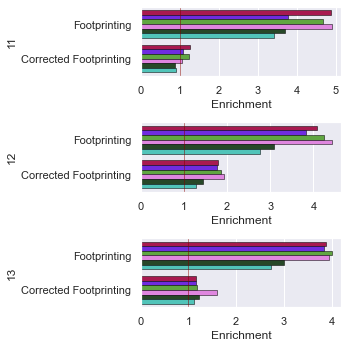

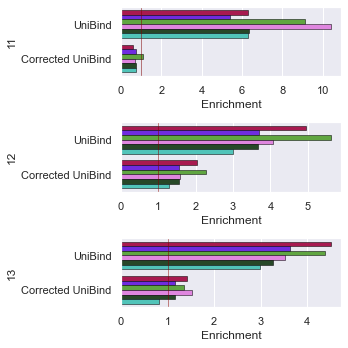

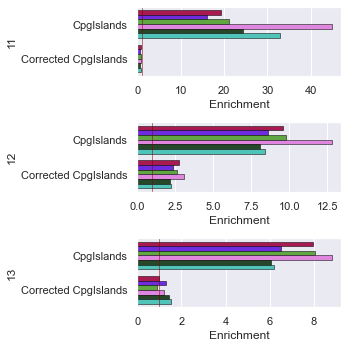

In [ ]:
analysis2title = {"cpg":"CpgIslands", "fp":"Footprinting", "unibind":"UniBind", "tfbs":"TFBS"}
analysis2header = {
 "fp":"consensus_footprints_and_collapsed_motifs_hg38", 
 "unibind":"hg38_compressed_TFBSs_unibind_robust",
 "cpg":"cpgIslandExt.hg38"
}

for analysis, header in analysis2header.items():
    all_df = pd.DataFrame()  
    for kmer in [11, 12, 13]:
        df = alt_subs_plotter(analysis, header, kmer)
        df['kmer'] = kmer
        all_df = pd.concat([all_df, df])
    all_df = all_df.reset_index(drop=True)
    combined_df = pd.DataFrame()
    for kmer in [11, 12, 13]:
        for mut in sigs.values():
            subdf = all_df[all_df.kmer == kmer]
            real = subdf[(subdf.variable == "Enrichment") & (subdf.subs_type == mut)]['value'].max()
            ctrl = subdf[(subdf.variable == "Control") & (subdf.subs_type == mut)]['value'].max()
            corr = real/ctrl
            df = pd.DataFrame([[real, corr]], columns=[analysis2title[analysis], f'Corrected {analysis2title[analysis]}'])
            df['kmer']=kmer
            df['Mutation']=mut
            combined_df = pd.concat([combined_df, df])
    plot_df = pd.melt(combined_df, id_vars=['Mutation', 'kmer'], value_vars=list(combined_df.columns)[:2])
    ### PLOT
    fig, ax = plt.subplots(nrows=3, sharex=False)
    for idx, kmer in enumerate([11, 12, 13]):
        g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
                        y="variable",
                        x="value",
                        hue="Mutation",
                        palette=subsD, linewidth=0.5, edgecolor='black',
                        ax = ax[idx])
        g.set_ylabel(f"{kmer}")
        g.set_xlabel("Enrichment")
        g.legend_.remove()
        g.axvline(1, color='maroon', lw=0.5)
    plt.tight_layout()
    plt.show()
    plt.close()

# 3'SS 5'SS

## Plot all

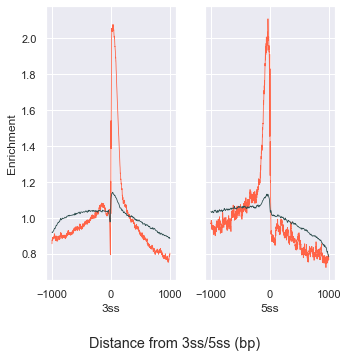

In [ ]:
filetypes = ["3ss", "5ss"]
analysis="ss"

all_df = pd.DataFrame()

for kmer in [13]:
	for idx, f in enumerate(filetypes): 
		plus=f"ss/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls.bed.txt..list.out.num"
		minus=f"ss/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls.bed.txt..list.out.num"
		plus_num = numsumfile_reader(plus)
		minus_num = numsumfile_reader_minus(minus)

		combined = {key: float(plus_num[key] + minus_num[key]) for key in plus_num}
		combined_mean = sum(list(combined.values())) / len(combined.values())
		enriched_mean = [i/combined_mean for i in combined.values()]
##### REPEAT FOR CONTROLS #####
		plus=f"ss/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls_controls_nulls.bed.txt..list.out.num"
		minus=f"ss/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls_controls_nulls.bed.txt..list.out.num"
		plus_num = numsumfile_reader(plus)
		minus_num = numsumfile_reader_minus(minus)

		combined_ctrl = {key: float(plus_num[key] + minus_num[key]) for key in plus_num}
		combined_mean = sum(list(combined_ctrl.values())) / len(combined_ctrl.values())
		ctrl_enriched_mean = [i/combined_mean for i in combined_ctrl.values()]

		bins = [i for i in range(-1000, 1000)]
		data=pd.DataFrame({"bins":bins, "Enrichment":enriched_mean, "Control":ctrl_enriched_mean})
		melted = pd.melt(data, id_vars=['bins'], value_vars=['Enrichment', 'Control'])
		melted['ss']=f
		all_df = pd.concat([all_df, melted])

### Plot
fig, axs = plt.subplots(ncols = 2, sharey=True)
for idx, sstype in enumerate(['3ss','5ss']):
    test = all_df[all_df['ss']==sstype]
    Final_array_smooth = gaussian_filter1d(test[test['variable']=="Control"]['value'], sigma=4)
    ctrl_df = pd.DataFrame([test.bins, Final_array_smooth], index=["bins", "value"]).T

    g = sns.lineplot(data = test[test['variable']=="Enrichment"],
                x="bins",
                y="value",
                ax=axs[idx],
                     color = "tomato",
                     lw=0.8)
    g = sns.lineplot(data = ctrl_df, 
                 x = "bins",
                 y="value",
                 ax=axs[idx],
                color = 'darkslategray', lw=0.8)
    g.set(ylabel='Enrichment', xlabel=f'{sstype}')
fig.supxlabel('Distance from 3ss/5ss (bp)')
plt.tight_layout()
plt.show()
plt.close()

### Plot All in barplot

In [ ]:
filetypes = ["3ss", "5ss"]
analysis="ss"

all_df = pd.DataFrame()

for kmer in [11, 12, 13]:
	for idx, f in enumerate(filetypes): 
		plus=f"ss/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls.bed.txt..list.out.num"
		minus=f"ss/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls.bed.txt..list.out.num"
		### Build plus dictionary
		plusD = numsumfile_reader(plus)
		### Build minus dictionary
		minusD = numsumfile_reader_minus()(minus)
		## add plus and minus scores
		combined = {}
		for k, v in plusD.items():
			plusV = plusD[k]
			minusV = minusD[k]
			combined[k] = plusV+minusV
		combined_mean = sum(list(combined.values())) / len(combined.values())
		enriched_mean = [i/combined_mean for i in combined.values()]
##### REPEAT FOR CONTROLS #####
		plus=f"ss/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls_controls_nulls.bed.txt..list.out.num"
		minus=f"ss/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls_controls_nulls.bed.txt..list.out.num"
		### Build plus dictionary
		plusD = numsumfile_reader(plus)
		### Build minus dictionary
		minusD = numsumfile_reader_minus(minus)
		## add plus and minus scores
		combined = {}
		for k, v in plusD.items():
			plusV = plusD[k]
			minusV = minusD[k]
			combined[k] = plusV+minusV
		combined_mean = sum(list(combined.values())) / len(combined.values())
		ctrl_enriched_mean = [i/combined_mean for i in combined.values()]

		data=pd.DataFrame({"bins":bins, "Enrichment":enriched_mean, "Control":ctrl_enriched_mean, "kmer":kmer})
		melted = pd.melt(data, id_vars=['bins', 'kmer'], value_vars=['Enrichment', 'Control'])
		melted['ss']=f
		all_df = pd.concat([all_df, melted])

In [ ]:
combined_df = pd.DataFrame()
for kmer in [11,12,13]:
    subdf = all_df[all_df.kmer == kmer]
    ss3 = subdf[(subdf.ss == "3ss") & (subdf.variable == "Enrichment")]['value'].max()
    ss5 = subdf[(subdf.ss == "5ss") & (subdf.variable == "Enrichment")]['value'].max()
    ctrl_ss3 = subdf[(subdf.ss == "3ss") & (subdf.variable == "Control")]['value'].max()
    ctrl_ss5 = subdf[(subdf.ss == "5ss") & (subdf.variable == "Control")]['value'].max()
    corr3 = ss3/ctrl_ss3
    corr5 = ss5/ctrl_ss5
    df = pd.DataFrame([[ss3, ss5, corr3, corr5]], columns=['3ss','5ss','Corrected 3ss', 'Corrected 5ss'])
    df['kmer']=kmer
    combined_df = pd.concat([combined_df, df])

In [ ]:
plot_df = pd.melt(combined_df, id_vars=['kmer'], value_vars=['3ss','5ss','Corrected 3ss','Corrected 5ss'])

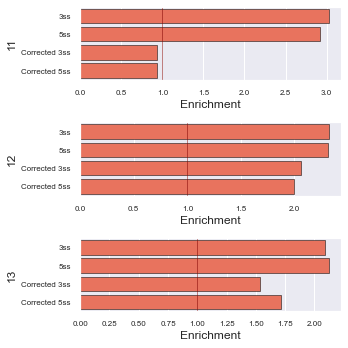

In [ ]:
fig, ax = plt.subplots(nrows=3, sharex=False)
for idx, kmer in enumerate([11,12,13]):
    g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
            y="variable",
            x="value",
            linewidth=0.5,
            edgecolor='black',
            color="tomato",
            ax = ax[idx])
    g.set_ylabel(f"{kmer}")
    g.set_xlabel("Enrichment")
    g.axvline(1, color="maroon", lw=0.5)
    g.tick_params(labelsize=8)
plt.tight_layout()
plt.show()
plt.close()

## Plot for each mut type

In [ ]:
muts = ["ins", "dels", "subs"]
filetypes = ["3ss", "5ss"]
analysis="ss"

all_df = pd.DataFrame()

for kmer in [11, 12, 13]:
	for mut in muts:
		for idx, f in enumerate(filetypes): 
			plus=f"ss/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls_{mut}.bed.txt..list.out.num"
			minus=f"ss/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls_{mut}.bed.txt..list.out.num"
			### Build plus dictionary
			plusD = numsumfile_reader(plus)
			minusD = numsumfile_reader_minus(minus)
			## add plus and minus scores per bin from plusD and minusD
			combined = {}
			for k, v in plusD.items():
				plusV = plusD[k]
				minusV = minusD[k]
				combined[k] = plusV+minusV
			combined_mean = sum(list(combined.values())) / len(combined.values())
			enriched_mean = [i/combined_mean for i in combined.values()]

			## Repeat for controls
			plus=f"ss/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls_controls_nulls_{mut}.bed.txt..list.out.num"
			minus=f"ss/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls_controls_nulls_{mut}.bed.txt..list.out.num"

			### Build plus dictionary
			plusD = numsumfile_reader(plus)
			### Build minus dictionary
			minusD = numsumfile_reader_minus(minus)
			## add plus and minus scores per bin from plusD and minusD
			combined = {}
			for k, v in plusD.items():
				plusV = plusD[k]
				minusV = minusD[k]
				combined[k] = plusV+minusV
			ctrl_combined_mean = sum(list(combined.values())) / len(combined.values())
			ctrl_enriched_mean = [i/ctrl_combined_mean for i in combined.values()]            
			
			data=pd.DataFrame({"bins":bins, "Enrichment":enriched_mean, "Control":ctrl_enriched_mean})
			melted = pd.melt(data, id_vars=['bins'], value_vars=['Enrichment','Control'])
			melted['ss'] = f 
			melted['type'] = mut
			melted['kmer'] = kmer
			all_df = pd.concat([all_df, melted])
all_df = all_df.reset_index()

In [ ]:
combined_df = pd.DataFrame()
for kmer in [11,12, 13]:
    for mut in muts:
        subdf = all_df[all_df.kmer == kmer]
        ss3 = subdf[(subdf.ss == "3ss") & (subdf.variable == "Enrichment") & (subdf.type == mut)]['value'].max()
        ss5 = subdf[(subdf.ss == "5ss") & (subdf.variable == "Enrichment") & (subdf.type == mut)]['value'].max()
        ctrl_ss3 = subdf[(subdf.ss == "3ss") & (subdf.variable == "Control") & (subdf.type == mut)]['value'].max()
        ctrl_ss5 = subdf[(subdf.ss == "5ss") & (subdf.variable == "Control") & (subdf.type == mut)]['value'].max()
        corr3 = ss3/ctrl_ss3
        corr5 = ss5/ctrl_ss5
        df = pd.DataFrame([[ss3, ss5, corr3, corr5]], columns=['3ss','5ss','Corrected 3ss','Corrected 5ss'])
        df['kmer']=kmer
        df['Mutation']=mut
        combined_df = pd.concat([combined_df, df])

In [ ]:
plot_df = pd.melt(combined_df, id_vars=['Mutation', 'kmer'], value_vars=['3ss','5ss','Corrected 3ss','Corrected 5ss'])

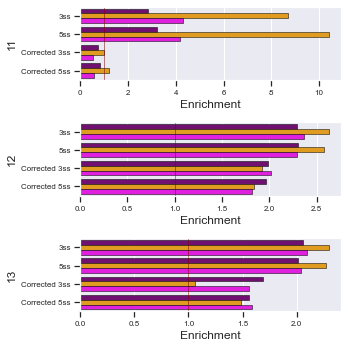

In [ ]:
my_pal = {"ins":"purple", "dels":"orange", "subs":"magenta"}
fig, ax = plt.subplots(nrows=3)
for idx, kmer in enumerate([11,12,13]):
    g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
                    y="variable",
                    x="value",
                    hue="Mutation",
                    palette=my_pal, linewidth=0.5, edgecolor='black',
                    ax = ax[idx])
    g.set_ylabel(f"{kmer}")
    g.set_xlabel("Enrichment")
    g.legend_.remove()
    g.axvline(1, color="maroon",lw=0.5)
    g.tick_params(labelsize=8,bottom=True, left=True)
plt.tight_layout()
plt.show()
plt.close()

## Plot for each subs type

In [ ]:
filetypes = ["3ss", "5ss"]
analysis="ss"

all_df = pd.DataFrame()

for kmer in [11, 12, 13]:
	for mut in sigs.keys():
		for idx, f in enumerate(filetypes): 
			# print(kmer, mut, idx,f)
			refsub = mut[0]
			altsub = mut[1]
			plus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.txt..list.out.num"
			minus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.txt..list.out.num"
			## equivalent substitution
			equiv_sig = equiv_sigs[(refsub, altsub)]
			plus_equiv=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.txt..list.out.num"
			minus_equiv=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.txt..list.out.num"
			dicL=[]
			for group in [(plus, minus), (plus_equiv, minus_equiv)]:
				### Build plus dictionary ###
				plusD = numsumfile_reader(group[0])
				minusD = numsumfile_reader_minus(group[1])
				dicL.append(plusD)
				dicL.append(minusD)
				#### dicL is list of four dictionaries, 2 plus 2 minus
			combined = {k:0 for k in dicL[0].keys()}
			for d in dicL:
				for k, v in d.items():
					combined[k] += v
			combined_mean = sum(list(combined.values())) / len(combined.values())
			enriched_mean = [i/combined_mean for i in combined.values()]
			
			#### REPEAT FOR  CONTROLS ####
			plus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.txt..list.out.num"
			minus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.txt..list.out.num"
			## equivalent substitution
			equiv_sig = equiv_sigs[(refsub, altsub)]
			plus_equiv=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.txt..list.out.num"
			minus_equiv=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.txt..list.out.num"
			dicL=[]
			for group in [(plus, minus), (plus_equiv, minus_equiv)]:
				### Build plus dictionary ###
				plusD = numsumfile_reader(group[0])
				### Build minus dictionary ###
				minusD = numsumfile_reader_minus(group[1])
				dicL.append(plusD)
				dicL.append(minusD)
				#### dicL is list of four dictionaries, 2 plus 2 minus
			combined = {k:0 for k in dicL[0].keys()}
			for d in dicL:
				for k, v in d.items():
					combined[k] += v
			combined_mean = sum(list(combined.values())) / len(combined.values())
			ctrl_enriched_mean = [i/combined_mean for i in combined.values()]
			
			subs_type = f"{refsub}>{altsub}"
			data=pd.DataFrame({"bins":bins, "Enrichment":enriched_mean, "Control": ctrl_enriched_mean, "subs_type":subs_type})
			melted = pd.melt(data, id_vars=['bins', 'subs_type'], value_vars=['Enrichment', 'Control'])
			melted['ss'] = f
			melted['kmer'] = kmer
			all_df = pd.concat([all_df, melted])

In [ ]:
combined_df = pd.DataFrame()
for kmer in [11,12,13]:
    for mut in sigs.values():
        subdf = all_df[all_df.kmer == kmer]
        ss3 = subdf[(subdf.ss == "3ss") & (subdf.variable == "Enrichment") & (subdf.subs_type == mut)]['value'].max()
        ss5 = subdf[(subdf.ss == "5ss") & (subdf.variable == "Enrichment") & (subdf.subs_type == mut)]['value'].max()
        ctrl_ss3 = subdf[(subdf.ss == "3ss") & (subdf.variable == "Control") & (subdf.subs_type == mut)]['value'].max()
        ctrl_ss5 = subdf[(subdf.ss == "5ss") & (subdf.variable == "Control") & (subdf.subs_type == mut)]['value'].max()
        corr3 = ss3/ctrl_ss3
        corr5 = ss5/ctrl_ss5
        df = pd.DataFrame([[ss3, ss5, corr3, corr5]], columns=['3ss','5ss','Corrected 3ss','Corrected 5ss'])
        df['kmer']=kmer
        df['Mutation']=mut
        combined_df = pd.concat([combined_df, df])

In [ ]:
plot_df = pd.melt(combined_df, id_vars=['Mutation', 'kmer'], value_vars=['3ss','5ss','Corrected 3ss','Corrected 5ss'])

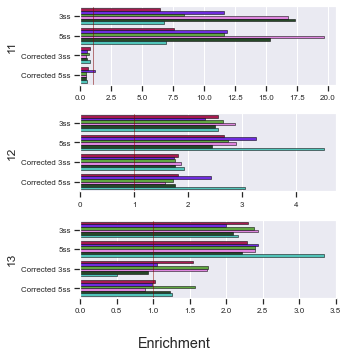

In [ ]:
fig, ax = plt.subplots(nrows=3, sharex=False)
for idx, kmer in enumerate([11,12,13]):
    g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
                    y="variable",
                    x="value",
                    hue="Mutation",
                    palette=subsD, linewidth=0.5, edgecolor='black',
                    ax = ax[idx])
    g.set_ylabel(f"{kmer}")
    g.set_xlabel("")
    g.legend_.remove()
    g.axvline(1, color='maroon', lw=0.5)
    g.tick_params(labelsize=8,bottom=True, left=True)
fig.supxlabel("Enrichment")
plt.tight_layout()
plt.show()
plt.close()

# TES and TSS:

### Plot all

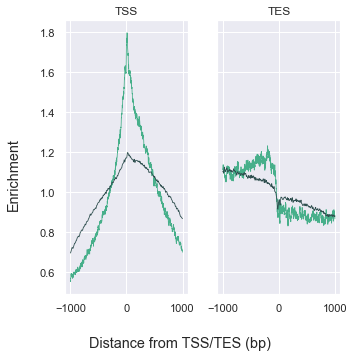

In [ ]:
filetypes = ["TSS", "TES"]
analysis="testss"

all_df = pd.DataFrame()

for kmer in [13]:
	for idx, f in enumerate(filetypes): 
		plus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls.bed.txt..list.out.num"
		minus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls.bed.txt..list.out.num"
		### Build plus dictionary
		plusD = numsumfile_reader(plus)
		### Build minus dictionary
		minusD = numsumfile_reader_minus(minus)		
		## add plus and minus scores
		combined = {}
		for k, v in plusD.items():
			plusV = plusD[k]
			minusV = minusD[k]
			combined[k] = plusV+minusV
		combined_mean = sum(list(combined.values())) / len(combined.values())
		enriched_mean = [i/combined_mean for i in combined.values()]
		
		## Repeat for controls
		plus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls_controls_nulls.bed.txt..list.out.num"
		minus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls_controls_nulls.bed.txt..list.out.num"

		### Build plus dictionary
		plusD = numsumfile_reader(plus)
		### Build minus dictionary
		minusD = numsumfile_reader_minus(minus)
		## add plus and minus scores per bin from plusD and minusD
		combined = {}
		for k, v in plusD.items():
			plusV = plusD[k]
			minusV = minusD[k]
			combined[k] = plusV+minusV
		ctrl_combined_mean = sum(list(combined.values())) / len(combined.values())
		ctrl_enriched_mean = [i/ctrl_combined_mean for i in combined.values()]

		data=pd.DataFrame({"bins":bins, "Enrichment":enriched_mean, "Control": ctrl_enriched_mean})
		melted = pd.melt(data, id_vars=['bins'], value_vars=['Enrichment','Control'])
		melted['ss']=f
		all_df = pd.concat([all_df, melted])  

### Plot
fig, axs = plt.subplots(ncols = 2, sharey=True)

for idx, sstype in enumerate(filetypes):
	test = all_df[all_df['ss']==sstype]
	Final_array_smooth = gaussian_filter1d(test[test['variable']=="Control"]['value'], sigma=4)
	ctrl_df = pd.DataFrame([test.bins, Final_array_smooth], index=["bins", "value"]).T
	
	g = sns.lineplot(data = test[test['variable']=="Enrichment"],
					x="bins",
					y="value",
					ax=axs[idx],
					 color = "#47AF8A",
					 lw=0.8)
	g = sns.lineplot(data = ctrl_df, 
				 x = "bins",
				 y="value",
				 ax=axs[idx],
				color = 'darkslategray', lw=0.8)
	g.set_title(sstype)
	g.set(ylabel='', xlabel='')
fig.supylabel(f'Enrichment')
fig.supxlabel('Distance from TSS/TES (bp)')
plt.tight_layout()
plt.show()
plt.close()

### Plot all in one barplot

In [ ]:
filetypes = ["TSS", "TES"]
analysis="testss"

all_df = pd.DataFrame()

for kmer in [11,12,13]:
    for idx, f in enumerate(filetypes): 
        plus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls.bed.txt..list.out.num"
        minus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls.bed.txt..list.out.num"
        ### Build plus dictionary
        plusD = numsumfile_reader(plus)
        ### Build minus dictionary
        minusD = numsumfile_reader_minus(minus)
        ## add plus and minus scores
        combined = {}
        for k, v in plusD.items():
            plusV = plusD[k]
            minusV = minusD[k]
            combined[k] = plusV+minusV
        combined_mean = sum(list(combined.values())) / len(combined.values())
        enriched_mean = [i/combined_mean for i in combined.values()]
        
        ## Repeat for controls
        plus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls_controls_nulls.bed.txt..list.out.num"
        minus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls_controls_nulls.bed.txt..list.out.num"
        ### Build plus dictionary
        plusD = numsumfile_reader(plus)
        ### Build minus dictionary
        minusD = numsumfile_reader_minus(minus)
        ## add plus and minus scores per bin from plusD and minusD
        combined = {}
        for k, v in plusD.items():
            plusV = plusD[k]
            minusV = minusD[k]
            combined[k] = plusV+minusV
        ctrl_combined_mean = sum(list(combined.values())) / len(combined.values())
        ctrl_enriched_mean = [i/ctrl_combined_mean for i in combined.values()]

        data=pd.DataFrame({"bins":bins, "Enrichment":enriched_mean, "Control": ctrl_enriched_mean, "kmer":kmer})
        
        melted = pd.melt(data, id_vars=['bins','kmer'], value_vars=['Enrichment','Control'])
        melted['ss']=f
        all_df = pd.concat([all_df, melted])

In [ ]:
combined_df = pd.DataFrame()
for kmer in [11,12,13]:
    subdf = all_df[all_df.kmer == kmer]
    tss = subdf[(subdf.ss == "TSS") & (subdf.variable == "Enrichment")]['value'].max()
    tes = subdf[(subdf.ss == "TES") & (subdf.variable == "Enrichment")]['value'].max()
    ctrl_TSS = subdf[(subdf.ss == "TSS") & (subdf.variable == "Control")]['value'].max()
    ctrl_TES = subdf[(subdf.ss == "TES") & (subdf.variable == "Control")]['value'].max()
    corr_TSS = tss/ctrl_TSS
    corr_TES = tes/ctrl_TES
    df = pd.DataFrame([[tss, tes, corr_TSS, corr_TES]], columns=['TSS','TES','Corrected TSS', 'Corrected TES'])
    df['kmer']=kmer
    combined_df = pd.concat([combined_df, df])

In [ ]:
plot_df = pd.melt(combined_df, id_vars=['kmer'], value_vars=['TSS','TES','Corrected TSS', 'Corrected TES'])

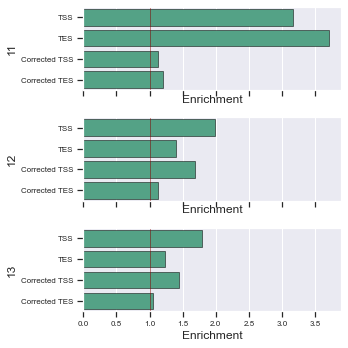

In [ ]:
fig, ax = plt.subplots(nrows=3, sharex=True)
for idx, kmer in enumerate([11,12,13]):
    g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
                    y="variable",
                    x="value",
                    linewidth=0.5,
                    edgecolor='black', color="#47AF8A",
                    ax = ax[idx])
    g.set_ylabel(f"{kmer}")
    g.set_xlabel("Enrichment")
    g.axvline(1, color="maroon", lw=0.5)
    g.tick_params(labelsize=8, bottom=True, left=True)
plt.tight_layout()
plt.show()
plt.close()

## Plot for each mut type

In [ ]:
muts = ["ins", "dels", "subs"]
filetypes = ["TSS", "TES"]
analysis="testss"


all_df = pd.DataFrame()
for kmer in [11, 12, 13]:
	for mut in muts:
		for idx, f in enumerate(filetypes): 
			plus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls_{mut}.bed.txt..list.out.num"
			minus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls_{mut}.bed.txt..list.out.num"
			### Build plus dictionary
			plusD = numsumfile_reader(plus)
			### Build minus dictionary
			minusD = numsumfile_reader_minus(minus)
			## add plus and minus scores per bin from plusD and minusD
			combined = {}
			for k, v in plusD.items():
				plusV = plusD[k]
				minusV = minusD[k]
				combined[k] = plusV+minusV
			combined_mean = sum(list(combined.values())) / len(combined.values())
			enriched_mean = [i/combined_mean for i in combined.values()]

			########### Repeat for controls
			plus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls_controls_nulls_{mut}.bed.txt..list.out.num"
			minus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls_controls_nulls_{mut}.bed.txt..list.out.num"
			### Build plus dictionary
			plusD = numsumfile_reader(plus)
			### Build minus dictionary
			minusD = numsumfile_reader_minus(minus)
			## add plus and minus scores per bin from plusD and minusD
			combined = {}
			for k, v in plusD.items():
				plusV = plusD[k]
				minusV = minusD[k]
				combined[k] = plusV+minusV
			ctrl_combined_mean = sum(list(combined.values())) / len(combined.values())
			ctrl_enriched_mean = [i/ctrl_combined_mean for i in combined.values()]

			data=pd.DataFrame({"bins":bins, "Enrichment":enriched_mean, "Control": ctrl_enriched_mean})
			melted = pd.melt(data, id_vars=['bins'], value_vars=['Enrichment', 'Control'])
			melted['ss'] = f 
			melted['type'] = mut
			melted['kmer'] = kmer
			all_df = pd.concat([all_df, melted])      
all_df = all_df.reset_index()

In [ ]:
combined_df = pd.DataFrame()
for kmer in [11,12, 13]:
    for mut in muts:
        subdf = all_df[(all_df.kmer == kmer) & (all_df.type == mut)]
        tss = subdf[(subdf.ss == "TSS") & (subdf.variable == "Enrichment")]['value'].max()
        tes = subdf[(subdf.ss == "TES") & (subdf.variable == "Enrichment")]['value'].max()
        ctrl_TSS = subdf[(subdf.ss == "TSS") & (subdf.variable == "Control")]['value'].max()
        ctrl_TES = subdf[(subdf.ss == "TES") & (subdf.variable == "Control")]['value'].max()
        corr_TSS = tss/ctrl_TSS
        corr_TES = tes/ctrl_TES
        df = pd.DataFrame([[tss, tes, corr_TSS, corr_TES]], columns=['TSS','TES','Corrected TSS', 'Corrected TES'])
        df['kmer']=kmer
        df['Mutation']=mut
        combined_df = pd.concat([combined_df, df])

In [ ]:
plot_df = pd.melt(combined_df, id_vars=['Mutation', 'kmer'], value_vars=['TSS','TES','Corrected TSS', 'Corrected TES'])

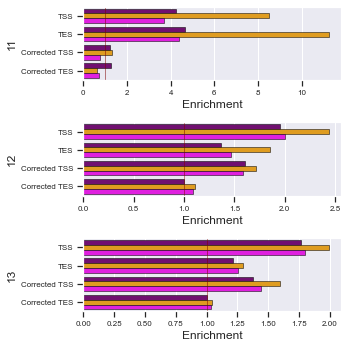

In [ ]:
my_pal = {"ins":"purple", "dels":"orange", "subs":"magenta"}
fig, ax = plt.subplots(nrows=3)
for idx, kmer in enumerate([11,12,13]):
    g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
                    y="variable",
                    x="value",
                    hue="Mutation",
                    palette=my_pal, linewidth=0.5, edgecolor='black',
                    ax = ax[idx])
    g.set_ylabel(f"{kmer}")
    g.set_xlabel("Enrichment")
    g.legend_.remove()
    g.axvline(1, color="maroon", lw=0.5)
    g.tick_params(labelsize=8,bottom=True, left=True)
plt.tight_layout()
plt.show()
plt.close()

## Plot for each subs type

In [ ]:
filetypes = ["TSS", "TES"]
analysis="testss"

all_df = pd.DataFrame()


for kmer in [11, 12, 13]:
	for mut in sigs.keys():
		for idx, f in enumerate(filetypes): 
			refsub = mut[0]
			altsub = mut[1]
			plus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.txt..list.out.num"
			minus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.txt..list.out.num"
			## equivalent substitution
			equiv_sig = equiv_sigs[(refsub, altsub)]
			plus_equiv=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.txt..list.out.num"
			minus_equiv=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.txt..list.out.num"
			dicL=[]
			for group in [(plus, minus), (plus_equiv, minus_equiv)]:
				### Build plus dictionary ###
				plusD = numsumfile_reader(group[0])
				### Build minus dictionary ###
				minusD = numsumfile_reader_minus(group[1])
				dicL.append(plusD)
				dicL.append(minusD)
				#### dicL is list of four dictionaries, 2 plus 2 minus
			combined = {k:0 for k in dicL[0].keys()}
			for d in dicL:
				for k, v in d.items():
					combined[k] += v
			combined_mean = sum(list(combined.values())) / len(combined.values())
			enriched_mean = [i/combined_mean for i in combined.values()]
			
			### REPEAT FOR CONTROLS ###
			plus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.txt..list.out.num"
			minus=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.txt..list.out.num"
			## equivalent substitution
			equiv_sig = equiv_sigs[(refsub, altsub)]
			plus_equiv=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_plus.score.mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.txt..list.out.num"
			minus_equiv=f"{analysis}/gencode.v42.chr_patch_hapl_scaff.annotation_{f}_minus.score.mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.txt..list.out.num"
			dicL=[]
			for group in [(plus, minus), (plus_equiv, minus_equiv)]:
				### Build plus dictionary ###
				plusD = numsumfile_reader(group[0])
				### Build minus dictionary ###
				minusD = numsumfile_reader_minus(group[1])
				dicL.append(plusD)
				dicL.append(minusD)
				#### dicL is list of four dictionaries, 2 plus 2 minus
			combined = {k:0 for k in dicL[0].keys()}
			for d in dicL:
				for k, v in d.items():
					combined[k] += v
			combined_mean = sum(list(combined.values())) / len(combined.values())
			ctrl_enriched_mean = [i/combined_mean for i in combined.values()]
			
			subs_type = f"{refsub}>{altsub}"
			data=pd.DataFrame({"bins":bins, "Enrichment":enriched_mean, "Control":ctrl_enriched_mean, "subs_type":subs_type})
			melted = pd.melt(data, id_vars=['bins', 'subs_type'], value_vars=['Enrichment','Control'])
			melted['ss'] = f
			melted['kmer'] = kmer
			all_df = pd.concat([all_df, melted])
all_df.head(3)

,bins,subs_type,variable,value,ss,kmer
0,-1000,C>A,Enrichment,0.0,TSS,11
1,-999,C>A,Enrichment,0.0,TSS,11
2,-998,C>A,Enrichment,0.0,TSS,11


In [ ]:
combined_df = pd.DataFrame()
for kmer in [11,12,13]:
    for mut in sigs.values():
        subdf = all_df[(all_df.kmer == kmer) & (all_df.subs_type == mut)]
        tss = subdf[(subdf.ss == "TSS") & (subdf.variable == "Enrichment") ]['value'].max()
        tes = subdf[(subdf.ss == "TES") & (subdf.variable == "Enrichment")]['value'].max()
        ctrl_TSS = subdf[(subdf.ss == "TSS") & (subdf.variable == "Control")]['value'].max()
        ctrl_TES = subdf[(subdf.ss == "TES") & (subdf.variable == "Control")]['value'].max()
        corr_TSS = tss/ctrl_TSS
        corr_TES = tes/ctrl_TES
        df = pd.DataFrame([[tss, tes, corr_TSS, corr_TES]], columns=['TSS','TES','Corrected TSS', 'Corrected TES'])
        df['kmer']=kmer
        df['Mutation']=mut
        combined_df = pd.concat([combined_df, df])

In [ ]:
plot_df = pd.melt(combined_df, id_vars=['Mutation', 'kmer'], value_vars=['TSS','TES','Corrected TSS', 'Corrected TES'])

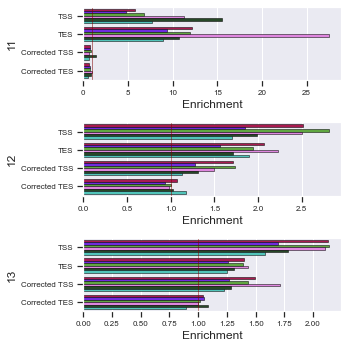

In [ ]:
fig, ax = plt.subplots(nrows=3)
for idx, kmer in enumerate([11,12,13]):
    g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
                    y="variable",
                    x="value",
                    hue="Mutation",
                    linewidth=0.5,
                    edgecolor='black', palette=subsD,
                    ax = ax[idx])
    g.set_ylabel(f"{kmer}")
    g.set_xlabel("Enrichment")
    g.legend_.remove()
    g.axvline(1, color="maroon", lw=0.5)
    g.tick_params(labelsize=8,bottom=True, left=True)
plt.tight_layout()
plt.show()
plt.close()

# UP TO HERE

## Plot Nucleosome/MNAseq

In [9]:
cell2GSM = {'Gm12878': 'GSM920558', 'K562': 'GSM920557'}
cell2GSM

{'Gm12878': 'GSM920558', 'K562': 'GSM920557'}

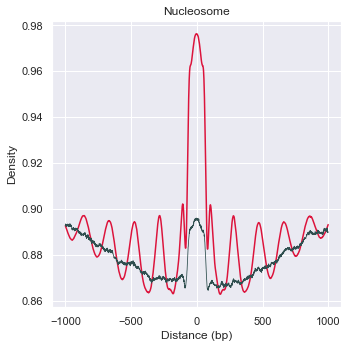

In [10]:
muts = ["dels", "subs", "ins"]
for kmer in [13]:
    all_df=pd.DataFrame()
    for cell in cell2GSM.keys():
        for mut in muts:
            numfile = f"nsome/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            sumfile = f"nsome/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"
            bins = numsumfile_reader(numfile).keys()
            numD = numsumfile_reader(numfile)
            sumD = numsumfile_reader(sumfile)
            combined = {}
            for k,v in numD.items(): #k is the bin number, v is the num Score
                score = (sumD[k])/v # sum Score / num Score
                combined[k] = score
            data=pd.DataFrame({"Distance (bp)":bins, "Density":list(combined.values()), "Mutation":mut, "DataType":"Nucleosome Density", "kmer":kmer})
            melted = pd.melt(data, id_vars=["Distance (bp)", "Mutation", "DataType", "kmer"], value_vars=['Density'])
            all_df = pd.concat([all_df,melted])

            ### Repeat for controls
            numfile=f"nsome/mutations_{kmer}bp_nulls_controls_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            sumfile=f"nsome/mutations_{kmer}bp_nulls_controls_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"
            bins = numsumfile_reader(numfile).keys()
            numD = numsumfile_reader(numfile)
            sumD = numsumfile_reader(sumfile)
            combined = {}
            for k,v in numD.items(): #k is the bin number, v is the num Score
                score = (sumD[k])/v # sum Score / num Score
                combined[k] = score
            data=pd.DataFrame({"Distance (bp)":bins, "Density":list(combined.values()), "Mutation":mut, "DataType":"Controls", "kmer":kmer})
            melted = pd.melt(data, id_vars=['Distance (bp)', "Mutation", "DataType", "kmer"], value_vars=['Density'])
            all_df = pd.concat([all_df,melted])
    
    #### Plot
    fig, ax = plt.subplots()
    g = sns.lineplot(x = 'Distance (bp)', 
                     y = 'value', 
                     data=all_df[all_df['DataType']=="Nucleosome Density"].reset_index(),
                     errorbar=None,
                     color = "crimson",
                    ax=ax)
    g = sns.lineplot(x = 'Distance (bp)', 
                     y = 'value', 
                     data=all_df[all_df['DataType']=="Controls"].reset_index(),
                     color='darkslategray', lw=0.8,
                     errorbar=None,
                     ax=ax)
    g.set(ylabel='Density', xlabel='Distance (bp)')

    plt.title(f"Nucleosome")
    plt.tight_layout()
    plt.show()
    plt.close()

11 subs Gm12878
11 subs Gm12878
11 subs Gm12878
11 subs Gm12878


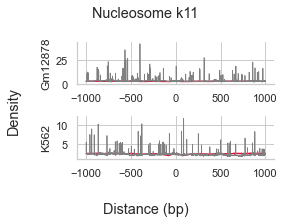

11 Enrichment is 2.667160333203273
11 Corrected enrichment is 0.14250646025247843


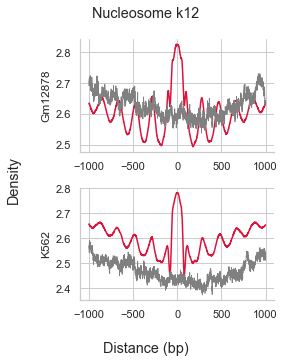

12 Enrichment is 2.8256330067000146
12 Corrected enrichment is 1.0722484751907324


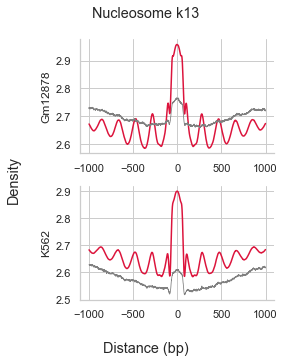

13 Enrichment is 2.957493758629731
13 Corrected enrichment is 1.0689046224693695


In [ ]:
muts = ["dels", "subs", "ins"]
for kmer in [11,12,13]:
    all_df=pd.DataFrame()
    fig, axs = plt.subplots(nrows=2)
    for idx, cell in enumerate(cell2GSM.keys()):
        for mut in muts:
            numfile = f"nsome/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            sumfile = f"nsome/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"
            bins = numsumfile_reader(numfile).keys()
            numD = numsumfile_reader(numfile)
            sumD = numsumfile_reader(sumfile)
            combined= {}
            for k,v in numD.items(): #k is the bin number, v is the num Score
                score = (sumD[k])/v # sum Score / num Score
                combined[k] = score

            data=pd.DataFrame({"Distance (bp)":bins, "Density":list(combined.values()), "Mutation":mut, "DataType":"Nucleosome Density", "kmer":kmer, "Cell":cell})
            melted = pd.melt(data, id_vars=["Distance (bp)", "Mutation", "DataType", "kmer", "Cell"], value_vars=['Density'])
            all_df = pd.concat([all_df,melted])

            ### Repeat for controls
            numfile=f"nsome/mutations_{kmer}bp_nulls_controls_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            sumfile=f"nsome/mutations_{kmer}bp_nulls_controls_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"
            bins = numsumfile_reader(numfile).keys()
            numD = numsumfile_reader(numfile)
            sumD = numsumfile_reader(sumfile)
            combined = {}
            for k,v in numD.items(): #k is the bin number, v is the num Score
                try:
                    score = (sumD[k])/v # sum Score / num Score
                    combined[k] = score
                except:
                    combined[k] = 0
                    print(kmer, mut, cell)
            data=pd.DataFrame({"Distance (bp)":bins, "Density":list(combined.values()), "Mutation":mut, "DataType":"Controls", "kmer":kmer, "Cell":cell})
            melted = pd.melt(data, id_vars=['Distance (bp)', "Mutation", "DataType", "kmer", "Cell"], value_vars=['Density'])
            all_df = pd.concat([all_df,melted])
            ### Use groupby to sum up the values for ins/dels/subs
        all_df = all_df.groupby(['Distance (bp)', 'DataType', 'kmer', "Cell"])['value'].sum().reset_index()
        
        #### Plot
        plotdf = all_df[all_df['Cell']==cell].reset_index()

        g = sns.lineplot(x = 'Distance (bp)', 
                         y = 'value', 
                         data=plotdf[plotdf['DataType']=="Nucleosome Density"].reset_index(),
                         errorbar=None,
                         color = "crimson",
                        ax=axs[idx])
        g = sns.lineplot(x = 'Distance (bp)', 
                         y = 'value', 
                         data=plotdf[plotdf['DataType']=="Controls"].reset_index(),
                         color='grey', lw=0.8,
                         errorbar=None,
                        ax=axs[idx])
        g.set(ylabel=f"{cell}", xlabel='')
    fig.supylabel('Density')
    fig.supxlabel('Distance (bp)')
    fig.suptitle(f"Nucleosome k{kmer}")
    plt.tight_layout()
    plt.show()
    plt.close()

    enrich_max = all_df[(all_df['DataType']=="Nucleosome Density") & (abs(all_df['Distance (bp)']) < 50)]['value'].values.max()
    ctrl_max = all_df[(all_df['DataType']=="Controls") & (abs(all_df['Distance (bp)']) < 50)]['value'].values.max()
    corr_enrich = enrich_max/ctrl_max
    print(f"{kmer} Enrichment is {enrich_max}")
    print(f"{kmer} Corrected enrichment is {corr_enrich}")


#### Plot all in one barplot

In [ ]:
muts = ["dels", "subs", "ins"]

all_df=pd.DataFrame()
for kmer in [11,12,13]:
    for idx, cell in enumerate(cell2GSM.keys()):
        for mut in muts:
            numfile = f"nsome/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            sumfile = f"nsome/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"
            bins = numsumfile_reader(numfile).keys()
            numD = numsumfile_reader(numfile)
            sumD = numsumfile_reader(sumfile)
            assert numD != sumD, "Num and Sum are same"
            combined = {}
            for k,v in numD.items(): #k is the bin number, v is the num Score
                score = (sumD[k])/v # sum Score / num Score
                combined[k] = score

            data=pd.DataFrame({"Distance (bp)":bins, "Density":list(combined.values()), "Mutation":mut, "Score":"Nucleosome Density", "kmer":kmer, "Cell":cell})
            melted = pd.melt(data, id_vars=["Distance (bp)", "Mutation", "Score", "kmer", "Cell"], value_vars=['Density'])
            all_df = pd.concat([all_df,melted])

            ### Repeat for controls
            numfile=f"nsome/mutations_{kmer}bp_nulls_controls_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            sumfile=f"nsome/mutations_{kmer}bp_nulls_controls_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"
            bins = numsumfile_reader(numfile).keys()
            numD = numsumfile_reader(numfile)
            sumD = numsumfile_reader(sumfile)
            assert numD != sumD, "Num and Sum are same"
            combined = {}
            for k,v in numD.items(): #k is the bin number, v is the num Score
                try:
                    score = (sumD[k])/v # sum Score / num Score
                    combined[k] = score 
                except:
                    print(kmer, cell, mut)
                    combined[k] = 0
            data=pd.DataFrame({"Distance (bp)":bins, "Density":list(combined.values()), "Mutation":mut, "Score":"Controls", "kmer":kmer, "Cell":cell})
            melted = pd.melt(data, id_vars=["Distance (bp)", "Mutation", "Score", "kmer", "Cell"], value_vars=['Density'])
            all_df = pd.concat([all_df,melted])
# all_df = all_df.reset_index(drop=True)
all_df = all_df.groupby(['Distance (bp)', 'Score', 'kmer', 'Cell'])['value'].sum().reset_index()
### Let's take average of the two cells
all_df = all_df.groupby(['Distance (bp)', 'Score', 'kmer'])['value'].mean().reset_index()
all_df

11 Gm12878 subs
11 Gm12878 subs
11 Gm12878 subs
11 Gm12878 subs


,Distance (bp),Score,kmer,value
0,-1000,Controls,11,2.643662
1,-1000,Controls,12,2.632636
2,-1000,Controls,13,2.677833
3,-1000,Nucleosome Density,11,2.598115
4,-1000,Nucleosome Density,12,2.645375
...,...,...,...,...
11995,999,Controls,12,2.577709
11996,999,Controls,13,2.668747
11997,999,Nucleosome Density,11,2.629188
11998,999,Nucleosome Density,12,2.642825


In [ ]:
combined_df = pd.DataFrame()
for kmer in [11,12,13]:
    subdf = all_df[all_df.kmer == kmer]
    enrich = subdf[(subdf.Score == "Nucleosome Density")]['value'].max()
    ctrl_enrich = subdf[(subdf.Score == "Controls")]['value'].max()
    corr = enrich/ctrl_enrich
    df = pd.DataFrame([[enrich, corr]], columns=["Nucleosome", f'Corrected \n Enrichment'])
    df['kmer']=kmer
    combined_df = pd.concat([combined_df, df])
combined_df

,Nucleosome,Corrected \n Enrichment,kmer
0,2.665137,0.119767,11
0,2.803685,1.056742,12
0,2.928714,1.089651,13


In [ ]:
plot_df = pd.melt(combined_df, id_vars=['kmer'], value_vars=["Nucleosome", f'Corrected \n Enrichment'])
print(plot_df)

   kmer                 variable     value
0    11               Nucleosome  2.665137
1    12               Nucleosome  2.803685
2    13               Nucleosome  2.928714
3    11  Corrected \n Enrichment  0.119767
4    12  Corrected \n Enrichment  1.056742
5    13  Corrected \n Enrichment  1.089651


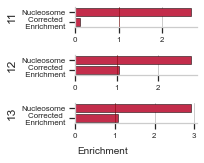

In [ ]:
sns.set(style="whitegrid", 
palette=sns.dark_palette("#47AF8A", reverse=True), 
rc={'figure.figsize':(3,2.5), 
    "axes.spines.right": False, 
    "axes.spines.top": False, 
    'font.size': 12})

fig, ax = plt.subplots(nrows=3, sharex=False)
for idx, kmer in enumerate([11,12,13]):
    g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
                    y="variable",
                    x="value",
                    color="crimson",
                    linewidth=0.5,
                    edgecolor='black',
                    ax = ax[idx])
    g.set_ylabel(f"{kmer}")
    g.set_xlabel("")
    g.axvline(1, color="maroon", lw=0.5)
    g.tick_params(labelsize=8, bottom=True, left=True)
    # g.legend_.remove()
fig.supxlabel("Enrichment", y=0.1, fontsize=10)
plt.tight_layout()
plt.savefig(f"figs/nsome/all_k11-13.svg", transparent=True)
plt.savefig(f"figs/nsome/all_k11-13.png")
plt.show()
plt.close()

### COPY TO FINAL

In [ ]:
muts = ["dels", "subs", "ins"]
cell2GSM = {'Gm12878': 'GSM920558', 'K562': 'GSM920557'}
analysis="nsome"

for kmer in [11,12,13]:
    for idx, cell in enumerate(cell2GSM.keys()):
        for mut in muts:
            numfile = f"{analysis}/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            sumfile = f"{analysis}/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"
            ### Repeat for controls
            numfile_ctrl=f"{analysis}/mutations_{kmer}bp_nulls_controls_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            sumfile_ctrl=f"{analysis}/mutations_{kmer}bp_nulls_controls_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"

            for fn in [numfile, sumfile, numfile_ctrl, sumfile_ctrl]:
                destination_path = f"FINAL/{fn}"
                # Create the destination directory if it doesn't exist
                destination_directory = os.path.dirname(destination_path)
                if not os.path.exists(destination_directory):
                    os.makedirs(destination_directory)            
#                 print(destination_path)
                shutil.copy2(fn, destination_path)

### Plot ins/dels/subs

#### Plot in one barplot

In [ ]:
muts = ["dels", "subs", "ins"]

all_df=pd.DataFrame()
for kmer in [11,12,13]:
    for idx, cell in enumerate(cell2GSM.keys()):
        for mut in muts:
            numfile = f"nsome/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            sumfile = f"nsome/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"
            bins = numsumfile_reader(numfile).keys()
            numD = numsumfile_reader(numfile)
            sumD = numsumfile_reader(sumfile)
            assert numD != sumD, "Num and Sum are same"
            combined = {}
            for k,v in numD.items(): #k is the bin number, v is the num Score
                score = (sumD[k])/v # sum Score / num Score
                combined[k] = score
            data=pd.DataFrame({"bins":bins, "Density":list(combined.values()), "Mutation":mut, "Score":"Nucleosome", "kmer":kmer})
            melted = pd.melt(data, id_vars=["bins", "Mutation", "Score", "kmer"], value_vars=['Density'])
            all_df = pd.concat([all_df,melted])

            ### Repeat for controls
            numfile=f"nsome/mutations_{kmer}bp_nulls_controls_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            sumfile=f"nsome/mutations_{kmer}bp_nulls_controls_nulls_{mut}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"
            bins = numsumfile_reader(numfile).keys()
            numD = numsumfile_reader(numfile)
            sumD = numsumfile_reader(sumfile)
            assert numD != sumD, "Num and Sum are same"
            combined = {}
            for k,v in numD.items(): #k is the bin number, v is the num Score
                try:
                    score = (sumD[k])/v # sum Score / num Score
                    combined[k] = score 
                except:
                    print(kmer, cell, mut)
                    combined[k] = 0
            data=pd.DataFrame({"bins":bins, "Density":list(combined.values()), "Mutation":mut, "Score":"Controls", "kmer":kmer})
            melted = pd.melt(data, id_vars=["bins", "Mutation", "Score", "kmer"], value_vars=['Density'])
            all_df = pd.concat([all_df,melted])
all_df = all_df.reset_index(drop=True)
all_df

11 Gm12878 subs
11 Gm12878 subs
11 Gm12878 subs
11 Gm12878 subs


,bins,Mutation,Score,kmer,variable,value
0,-1000,dels,Nucleosome,11,Density,0.841608
1,-999,dels,Nucleosome,11,Density,0.838386
2,-998,dels,Nucleosome,11,Density,0.840067
3,-997,dels,Nucleosome,11,Density,0.818407
4,-996,dels,Nucleosome,11,Density,0.833072
...,...,...,...,...,...,...
71995,995,ins,Controls,13,Density,0.860211
71996,996,ins,Controls,13,Density,0.860524
71997,997,ins,Controls,13,Density,0.860315
71998,998,ins,Controls,13,Density,0.860447


In [ ]:
combined_df = pd.DataFrame()
for kmer in [11,12,13]:
    for mut in muts:
        subdf = all_df[all_df.kmer == kmer]
        enrich = subdf[(subdf.Score == "Nucleosome") & (subdf.Mutation == mut)]['value'].max()
        ctrl_enrich = subdf[(subdf.Score == "Controls") & (subdf.Mutation == mut)]['value'].max()
        corr = enrich/ctrl_enrich
        df = pd.DataFrame([[enrich, corr]], columns=["Nucleosome", f'Corrected \n Enrichment'])
        df['kmer']=kmer
        df['Mutation']=mut
        combined_df = pd.concat([combined_df, df])
combined_df

,Nucleosome,Corrected \n Enrichment,kmer,Mutation
0,0.902258,1.017026,11,dels
0,0.903126,0.022163,11,subs
0,0.933459,0.092239,11,ins
0,0.952918,1.003904,12,dels
0,0.933092,1.022546,12,subs
0,0.940792,1.026087,12,ins
0,0.996823,1.050322,13,dels
0,0.977612,1.062711,13,subs
0,0.983187,1.071455,13,ins


In [ ]:
plot_df = pd.melt(combined_df, id_vars=['kmer', 'Mutation'], value_vars=["Nucleosome", f'Corrected \n Enrichment'])
print(plot_df)

    kmer Mutation                 variable     value
0     11     dels               Nucleosome  0.902258
1     11     subs               Nucleosome  0.903126
2     11      ins               Nucleosome  0.933459
3     12     dels               Nucleosome  0.952918
4     12     subs               Nucleosome  0.933092
5     12      ins               Nucleosome  0.940792
6     13     dels               Nucleosome  0.996823
7     13     subs               Nucleosome  0.977612
8     13      ins               Nucleosome  0.983187
9     11     dels  Corrected \n Enrichment  1.017026
10    11     subs  Corrected \n Enrichment  0.022163
11    11      ins  Corrected \n Enrichment  0.092239
12    12     dels  Corrected \n Enrichment  1.003904
13    12     subs  Corrected \n Enrichment  1.022546
14    12      ins  Corrected \n Enrichment  1.026087
15    13     dels  Corrected \n Enrichment  1.050322
16    13     subs  Corrected \n Enrichment  1.062711
17    13      ins  Corrected \n Enrichment  1.

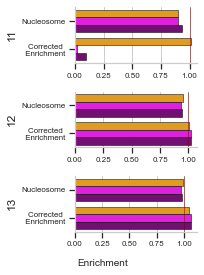

In [ ]:
# plot_df
sns.set(style="whitegrid", 
palette=sns.dark_palette("#47AF8A", reverse=True), 
rc={'figure.figsize':(3,4), 
    "axes.spines.right": False, 
    "axes.spines.top": False, 
    'font.size': 12})

fig, ax = plt.subplots(nrows=3, sharex=False)
for idx, kmer in enumerate([11,12,13]):
    g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
                    y="variable",
                    x="value",
                    hue="Mutation",
                    linewidth=0.5,
                    edgecolor='black',
                    palette=my_pal,
                    ax = ax[idx])
    g.set_ylabel(f"{kmer}")
    g.set_xlabel("")
    g.axvline(1, color="maroon", lw=0.5)
    g.legend_.remove()
    g.tick_params(labelsize=8,bottom=True, left=True)
fig.supxlabel("Enrichment",)
plt.tight_layout()
plt.savefig(f"figs/nsome/muts_k11-13.svg", transparent=True)
plt.savefig(f"figs/nsome/muts_k11-13.png")
plt.show()
plt.close()

### Plot for each subs type

In [ ]:
all_df = pd.DataFrame()
for kmer in [11,12,13]:
    for cell in cell2GSM.keys():
        for mut in sigs.keys():
            # print(kmer, mut)
            refsub = mut[0]
            altsub = mut[1]
            numfile = f"nsome/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            sumfile = f"nsome/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"
            ## equivalent substitution
            equiv_sig = equiv_sigs[(refsub, altsub)]
            equiv_numfile = f"nsome/mutations_{kmer}bp_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            equiv_sumfile = f"nsome/mutations_{kmer}bp_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"
            bins = numsumfile_reader(numfile).keys()
            combined = {k:0 for k in bins}
            for group in [(numfile, sumfile), (equiv_numfile, equiv_sumfile)]:
                ### Build ref/alt dictionary ###
                numD = numsumfile_reader(numfile)
                sumD = numsumfile_reader(sumfile)
                bins = numD.keys()
                for k,v in numD.items():
                    score = (sumD[k])/v # sum Score / num Score
                    combined[k] += score
            combined_mean = sum(list(combined.values())) / len(combined.values())
            enriched_mean = [i/combined_mean for i in combined.values()]

            #### REPEAT FOR CONTROLS ####
            refsub = mut[0]
            altsub = mut[1]                
            numfile=f"nsome/mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            sumfile=f"nsome/mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"
            ## equivalent substitution
            equiv_sig = equiv_sigs[(refsub, altsub)]
            equiv_numfile=f"nsome/mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            equiv_sumfile=f"nsome/mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"
            bins = numsumfile_reader(numfile).keys()
            combined = {k:0 for k in bins}
            for group in [(numfile, sumfile), (equiv_numfile, equiv_sumfile)]:
                ### Build ref/alt dictionary ###
                numD = numsumfile_reader(numfile)
                sumD = numsumfile_reader(sumfile)
                bins = numD.keys()
                for k,v in numD.items():
                    score = (sumD[k])/(v) # sum Score / num Score
                    combined[k] += score
            combined_mean = sum(list(combined.values())) / len(combined.values())
            ctrl_enriched_mean = [i/combined_mean for i in combined.values()]     

            subs_type = f"{refsub}>{altsub}"
            data=pd.DataFrame({"bins":bins, "Enrichment":enriched_mean, 
                               "Control":ctrl_enriched_mean, 
                               "subs_type":subs_type, 
                               "kmer":kmer, 
                               "cell":cell})
            melted = pd.melt(data, id_vars=['bins', 'subs_type', 'cell', 'kmer'], value_vars=['Enrichment','Control'])
            all_df = pd.concat([all_df, melted])

In [ ]:
all_df.head(3)

,bins,subs_type,cell,kmer,variable,value
0,-1000,C>A,Gm12878,11,Enrichment,1.151030
1,-999,C>A,Gm12878,11,Enrichment,1.143185
2,-998,C>A,Gm12878,11,Enrichment,1.176696


In [ ]:
combined_df = pd.DataFrame()
for kmer in [11,12,13]:
    for mut in sigs.values():
        subdf = all_df[(all_df.kmer == kmer) & (all_df.subs_type == mut)]
        enriched_max = subdf[(subdf.variable == "Enrichment") ]['value'].max()
        ctrl_max = subdf[(subdf.variable == "Control")]['value'].max()
        corr_max = enriched_max/ctrl_max
        df = pd.DataFrame([[enriched_max, corr_max]], columns=['Nucleosome', 'Corrected'])
        df['kmer']=kmer
        df['Mutation']=mut
        combined_df = pd.concat([combined_df, df])
combined_df

,Nucleosome,Corrected,kmer,Mutation
0,1.283649,1.042161,11,C>A
0,1.152674,1.080509,11,C>G
0,1.286914,1.104516,11,C>T
0,1.275290,1.036922,11,T>A
0,1.117157,1.062711,11,T>C
0,1.126859,1.018712,11,T>G
0,1.139882,1.066412,12,C>A
0,1.134707,1.122872,12,C>G
0,1.129912,1.051878,12,C>T
0,1.074093,1.035957,12,T>A


In [ ]:
plot_df = pd.melt(combined_df, id_vars=['Mutation', 'kmer'], value_vars=['Nucleosome', 'Corrected'])
plot_df.head(3)

,Mutation,kmer,variable,value
0,C>A,11,Nucleosome,1.283649
1,C>G,11,Nucleosome,1.152674
2,C>T,11,Nucleosome,1.286914


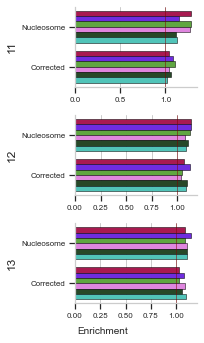

In [ ]:
sns.set(style="whitegrid", 
palette=sns.dark_palette("#47AF8A", reverse=True), 
rc={'figure.figsize':(3,5), 
    "axes.spines.right": False, 
    "axes.spines.top": False, 
    'font.size': 12})

fig, ax = plt.subplots(nrows=3)
for idx, kmer in enumerate([11,12,13]):
    g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
                    y="variable",
                    x="value",
                    hue="Mutation",
                    palette=subsD, linewidth=0.5, edgecolor='black',
                    ax = ax[idx])
    g.set_ylabel(f"{kmer}")
    g.set_xlabel("")
    g.legend_.remove()
    g.axvline(1, color="maroon", lw=0.5)
    g.tick_params(labelsize=8,bottom=True, left=True)
fig.supxlabel("Enrichment",)
plt.tight_layout()
plt.savefig(f"figs/nsome/subs_k11-13.svg", transparent=True)
plt.savefig(f"figs/nsome/subs_k11-13.png")
plt.show()
plt.close()

### COPY TO FINAL

In [ ]:
cell2GSM = {'Gm12878': 'GSM920558', 'K562': 'GSM920557'}
analysis="nsome"

for kmer in [11,12,13]:
    for idx, cell in enumerate(cell2GSM.keys()):
        for sig in sigs:
            refsub, altsub = sig
            equiv_sig = equiv_sigs[(refsub, altsub)]

            numfile = f"{analysis}/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            sumfile = f"{analysis}/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"
            ## equivalent substitution
            equiv_numfile = f"{analysis}/mutations_{kmer}bp_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            equiv_sumfile = f"{analysis}/mutations_{kmer}bp_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"

            #### REPEAT FOR CONTROLS ####
            numfile_ctrl=f"nsome/mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            sumfile_ctrl=f"nsome/mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"
            ## equivalent substitution
            equiv_numfile_ctrl=f"nsome/mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.num"
            equiv_sumfile_ctrl=f"nsome/mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.score.{cell2GSM[cell]}_hg38_wgEncodeSydhNsome{cell}Sig.bedGraph.list.out.sum"            

            for fn in [numfile, sumfile, equiv_numfile, equiv_sumfile, numfile_ctrl, sumfile_ctrl, equiv_numfile_ctrl, equiv_sumfile_ctrl]:
                destination_path = f"FINAL/{fn}"
                # Create the destination directory if it doesn't exist
                destination_directory = os.path.dirname(destination_path)
                if not os.path.exists(destination_directory):
                    os.makedirs(destination_directory)            
#                 print(destination_path)
                shutil.copy2(fn, destination_path)

## Plot WGBS

In [ ]:
celltypes = ['ENCFF441OSB', 'ENCFF865OXJ', 'ENCFF896GOF', 'ENCFF524MTO', 'ENCFF283YAZ']

In [ ]:
muts = ['ins','dels','subs']
### THIS IS GOOD ###
for kmer in [11,12,13]:
    for cell in celltypes:
        for mut in muts:
            ## Check files
            numfile = f"wgbs/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell}.bedGraph.list.out.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell}.bedGraph.list.out.sum"
            filechecker(numfile)
            filechecker(sumfile)
            ## Check controls
            numfile = f"wgbs/mutations_{kmer}bp_nulls_controls_{mut}.bed.score.{cell}.bedGraph.list.out.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_controls_{mut}.bed.score.{cell}.bedGraph.list.out.sum"
            filechecker(numfile)
            filechecker(sumfile)    

In [ ]:
### THIS IS GOOD ###
for kmer in [11, 12, 13]:
    for cell in celltypes:
        for sig in sigs:
            refsub, altsub = sig
            numfile = f"wgbs2/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.out.num"
            sumfile = f"wgbs2/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.out.sum"
            filechecker(numfile)
            filechecker(sumfile)
            numfile = f"wgbs2/mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.out.num"
            sumfile = f"wgbs2/mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.out.sum"
            filechecker(numfile)
            filechecker(sumfile)
            ## Repeat for subs
            equiv_ref, equiv_sub = equiv_sigs[(refsub, altsub)]
            numfile = f"wgbs2/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.out.num"
            sumfile = f"wgbs2/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.out.sum"
            filechecker(numfile)
            filechecker(sumfile)
            numfile = f"wgbs2/mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.out.num"
            sumfile = f"wgbs2/mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.out.sum"
            filechecker(numfile)
            filechecker(sumfile)

In [ ]:
### THIS IS GOOD ###
for kmer in [11,12,13]:
    for cell in celltypes:
        for sig in sigs:
            refsub, altsub = sig
            numfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            filechecker(numfile)
            filechecker(sumfile)
            numfile = f"wgbs/mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            filechecker(numfile)
            filechecker(sumfile)
            ## Repeat for subs
            equiv_ref, equiv_sub = equiv_sigs[(refsub, altsub)]
            numfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            filechecker(numfile)
            filechecker(sumfile)
            numfile = f"wgbs/mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            filechecker(numfile)
            filechecker(sumfile)

In [ ]:
### Add up the ctrl substitution subtypes to create ctrl subs file
kmer=13
cell_types = ["ENCFF441OSB", "ENCFF524MTO"]

for cell in cell_types:
    output = f"wgbs3/mutations_{kmer}bp_nulls_controls_subs.bed.score.{cell}.bedGraph.list.out.num"
    all_df = pd.DataFrame()
    for sig in sigs:
        refsub, altsub = sig
        num_fn = f"wgbs3/mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.out.num"
        filechecker(num_fn)
        ### sum up the NUM files
        num_df = pd.read_csv(num_fn,sep="\t")
        all_df = pd.concat([all_df,num_df])
    all_df = pd.DataFrame(all_df.sum()).T
    all_df.to_csv(output, sep="\t", index=None)
    
for cell in cell_types:
    output = f"wgbs3/mutations_{kmer}bp_nulls_controls_subs.bed.score.{cell}.bedGraph.list.out.sum"
    all_df = pd.DataFrame()
    for sig in sigs:
        refsub, altsub = sig
        num_fn = f"wgbs3/mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.out.sum"
        filechecker(num_fn)
        ### sum up the NUM files
        num_df = pd.read_csv(num_fn,sep="\t")
        all_df = pd.concat([all_df,num_df])
    all_df = pd.DataFrame(all_df.sum()).T
    all_df.to_csv(output, sep="\t", index=None)


In [ ]:
def filechecker_returns(filename):
    try:
        if os.path.isfile(filename) == True:
            ds_df = pd.read_csv(filename, sep="\t")
            if ds_df.iloc[0,:].sum() == 0:
                print(f"All zeros: {filename}")
                result = "bad"
            if ds_df.iloc[0,:].sum() != 0:
                result = "good"
                # print(f"GOOD: {filename}")
        elif os.path.isfile(filename) == False:
            print(f"Nonexistant file: {filename}")
            result = "bad"
    except IndexError:
        print(f"No second row: {filename}")
        result = "bad"
    return result

In [ ]:
file2result = {}

for kmer in [13]:
    for cell in celltypes:
        for sig in sigs:
            refsub, altsub = sig
            numfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            file2result[numfile] = filechecker_returns(numfile)
            file2result[sumfile] = filechecker_returns(sumfile)
            numfile = f"wgbs/mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            file2result[numfile] = filechecker_returns(numfile)
            file2result[sumfile] = filechecker_returns(sumfile)
            ## Repeat for subs
            equiv_ref, equiv_sub = equiv_sigs[(refsub, altsub)]
            numfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            file2result[numfile] = filechecker_returns(numfile)
            file2result[sumfile] = filechecker_returns(sumfile)
            numfile = f"wgbs/mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            file2result[numfile] = filechecker_returns(numfile)
            file2result[sumfile] = filechecker_returns(sumfile)

In [ ]:
for k,v in file2result.items():
    if v == "bad":
        filename = k.split("wgbs/")[1].replace("ouut", "out")
        # print(filename)
        new = f"/wynton/group/ahituv/candace/num/{filename}"
        rename = filename.replace("out", "ouut")
        os.system(f'cp {new} /wynton/group/ahituv/cc_datasets/np/num/wgbs2/{rename}')
        # print(new)

### Plot All: Need to add up each mutation type because all files are too big

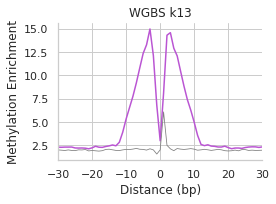

2.048946087981596
Enrichment: 2.9749048008943864
Corrected enrichment: 1.451919510398122


In [ ]:
#### Need to add up each mutation type because all files are too big!!!!!!!
muts = ['ins','dels','subs']
kmer=13
all_df = pd.DataFrame()
for cell in celltypes:
    totalNum = {k:0 for k in range(-1000,1000)}
    totalSum = {k:0 for k in range(-1000,1000)}
    totalScores = {k:0 for k in range(-1000,1000)}
    for mut in muts:
        numfile = f"wgbs/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell}.bedGraph.list.out.num"
        sumfile = f"wgbs/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell}.bedGraph.list.out.sum"
        # print(numfile,sumfile)
        numD = numsumfile_reader(numfile)
        sumD = numsumfile_reader(sumfile)
        bins = numD.keys()
        assert numD != sumD, "Num and Sum are same"
        for k,v in numD.items():
            totalNum[k] += v
        for k,v in sumD.items():
            totalSum[k] += v
    for bin_num in range(-1000, 1000):
        score = totalSum[bin_num]/totalNum[bin_num]
        totalScores[bin_num] = score
    data=pd.DataFrame({"Distance (bp)":bins, 
                       "Cell Type": cell, 
                       "Methylation Enrichment":list(totalScores.values()), "DataType":"Real"})
    all_df = pd.concat([all_df, data])
    ### REPEAT FOR CONTROLS
    totalNum = {k:0 for k in range(-1000,1000)}
    totalSum = {k:0 for k in range(-1000,1000)}
    totalScores = {k:0 for k in range(-1000,1000)}
    for mut in muts:
        numfile = f"wgbs/mutations_{kmer}bp_nulls_controls_{mut}.bed.score.{cell}.bedGraph.list.out.num"
        sumfile = f"wgbs/mutations_{kmer}bp_nulls_controls_{mut}.bed.score.{cell}.bedGraph.list.out.sum"
        # print(numfile,sumfile)
        numD = numsumfile_reader(numfile)
        sumD = numsumfile_reader(sumfile)
        bins = numD.keys()
        assert numD != sumD, "Num and Sum are same"
        for k,v in numD.items():
            totalNum[k] += v
        for k,v in sumD.items():
            totalSum[k] += v
    for bin_num in range(-1000, 1000):
        score = totalSum[bin_num]/totalNum[bin_num]
        totalScores[bin_num] = score
    data=pd.DataFrame({"Distance (bp)":bins, 
                       "Cell Type": cell, 
                       "Methylation Enrichment":list(totalScores.values()), "DataType":"Control"})
    all_df = pd.concat([all_df, data])
all_df["Distance (bp)"] = all_df["Distance (bp)"] + 2

colors = ["#9DBCAC", "#F28963", "#4C797B", "#CB544B", "#BD45BF"]
#### Plot
sns.set(style="whitegrid", 
    palette="muted", 
    rc={'figure.figsize':(4,3), 
        "axes.spines.right": False, 
        "axes.spines.top": False, 
        'font.size': 12})

fig, ax = plt.subplots()
g = sns.lineplot(x = 'Distance (bp)', 
                 y = 'Methylation Enrichment', 
                 # hue="Cell Type", 
                 color = "mediumorchid", estimator=np.median,
                 data=all_df[all_df['DataType']=="Real"].reset_index(),
                 errorbar=None,
                 ax=ax,
                 # palette=dict(zip(celltypes, colors))
                )
g = sns.lineplot(x = 'Distance (bp)', 
                 y = 'Methylation Enrichment', 
                 # hue="Cell Type", 
                 data=all_df[all_df['DataType']=="Control"].reset_index(),
                 color='grey', estimator=np.median,
                 lw=0.8,
                 errorbar=None,
                 ax=ax)
# g.legend_.remove()
plt.title(f"WGBS k{kmer}")
plt.xlim(-30,30)
plt.tight_layout()
plt.savefig(f"figs/wgbs/all.png")
plt.savefig(f"figs/wgbs/all.svg")
plt.show()
plt.close()


### Calculate enrichment within 30 basepairs
enrich_max = np.median(all_df[(all_df['DataType']=="Real") & (abs(all_df['Distance (bp)']) < 30)]['Methylation Enrichment'].values)
ctrl_max = np.median(all_df[(all_df['DataType']=="Control") & (abs(all_df['Distance (bp)']) < 30)]['Methylation Enrichment'].values)
print(ctrl_max)
corr_enrich = enrich_max/ctrl_max
print(f"Enrichment: {enrich_max}")
print(f"Corrected enrichment: {corr_enrich}")

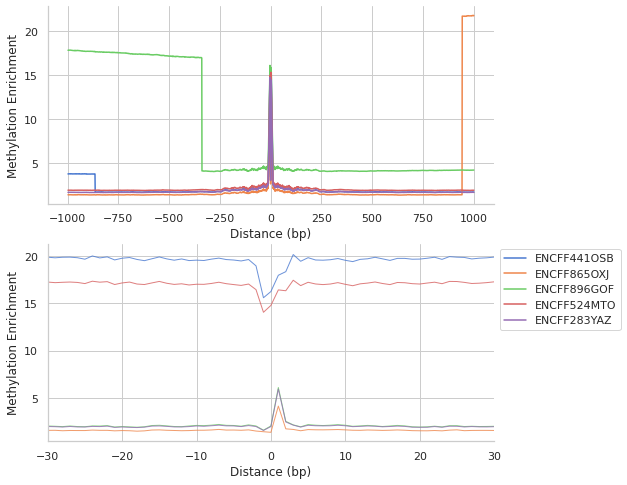

In [ ]:
#### Need to add up each mutation type because all files are too big!!!!!!!
muts = ['ins','dels','subs']
kmer=13
all_df = pd.DataFrame()
for cell in celltypes:
    totalNum = {k:0 for k in range(-1000,1000)}
    totalSum = {k:0 for k in range(-1000,1000)}
    totalScores = {k:0 for k in range(-1000,1000)}
    for mut in muts:
        numfile = f"wgbs/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell}.bedGraph.list.out.num"
        sumfile = f"wgbs/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell}.bedGraph.list.out.sum"
        # print(numfile,sumfile)
        numD = numsumfile_reader(numfile)
        sumD = numsumfile_reader(sumfile)
        bins = numD.keys()
        assert numD != sumD, "Num and Sum are same"
        for k,v in numD.items():
            totalNum[k] += v
        for k,v in sumD.items():
            totalSum[k] += v
    for bin_num in range(-1000, 1000):
        score = totalSum[bin_num]/totalNum[bin_num]
        totalScores[bin_num] = score
    data=pd.DataFrame({"Distance (bp)":bins, 
                       "Cell Type": cell, 
                       "Methylation Enrichment":list(totalScores.values()), "DataType":"Real"})
    all_df = pd.concat([all_df, data])
    ### REPEAT FOR CONTROLS
    totalNum = {k:0 for k in range(-1000,1000)}
    totalSum = {k:0 for k in range(-1000,1000)}
    totalScores = {k:0 for k in range(-1000,1000)}
    for mut in muts:
        numfile = f"wgbs/mutations_{kmer}bp_nulls_controls_{mut}.bed.score.{cell}.bedGraph.list.out.num"
        sumfile = f"wgbs/mutations_{kmer}bp_nulls_controls_{mut}.bed.score.{cell}.bedGraph.list.out.sum"
        # print(numfile,sumfile)
        numD = numsumfile_reader(numfile)
        sumD = numsumfile_reader(sumfile)
        bins = numD.keys()
        assert numD != sumD, "Num and Sum are same"
        for k,v in numD.items():
            totalNum[k] += v
        for k,v in sumD.items():
            totalSum[k] += v
    for bin_num in range(-1000, 1000):
        score = totalSum[bin_num]/totalNum[bin_num]
        totalScores[bin_num] = score
    data=pd.DataFrame({"Distance (bp)":bins, 
                       "Cell Type": cell, 
                       "Methylation Enrichment":list(totalScores.values()), "DataType":"Control"})
    all_df = pd.concat([all_df, data])
all_df["Distance (bp)"] = all_df["Distance (bp)"] + 2

colors = ["#9DBCAC", "#F28963", "#4C797B", "#CB544B", "#BD45BF"]
#### Plot
sns.set(style="whitegrid", 
    palette="muted", 
    rc={'figure.figsize':(8,8), 
        "axes.spines.right": False, 
        "axes.spines.top": False, 
        'font.size': 12})

fig, ax = plt.subplots(nrows=2)

g1 = sns.lineplot(x = 'Distance (bp)', 
                 y = 'Methylation Enrichment', 
                 hue="Cell Type", 
                 color = "mediumorchid",
                 estimator=np.median,
                 data=all_df[all_df['DataType']=="Real"].reset_index(),
                 errorbar=None,
                 ax=ax[0],
                )
g1.legend_.remove()
g1 = sns.lineplot(x = 'Distance (bp)', 
                 y = 'Methylation Enrichment', 
                 hue="Cell Type", 
                 data=all_df[all_df['DataType']=="Control"].reset_index(),
                 color='grey', estimator=np.median,
                 lw=1,
                 errorbar=None, alpha=0.8,
                 ax=ax[1])

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.title(f"WGBS k{kmer}")
plt.xlim(-30,30)
# plt.tight_layout()
plt.show()
plt.close()

In [ ]:
### which lines for controls are messed up?

test_ctrl = all_df[all_df['DataType']=="Control"].reset_index()
for celltype in set(test_ctrl['Cell Type']):
    max_cell_enrich = test_ctrl[test_ctrl['Cell Type'] == celltype]['Methylation Enrichment'].max()
    print(f"Max Enrichment for {celltype} is {max_cell_enrich}")

Max Enrichment for ENCFF283YAZ is 5.9276020207416344
Max Enrichment for ENCFF865OXJ is 4.1244959447307235
Max Enrichment for ENCFF441OSB is 20.374437722123027
Max Enrichment for ENCFF896GOF is 6.0911624356665275
Max Enrichment for ENCFF524MTO is 18.056186508431352


#### Plot 11/12 All: DONE

In [ ]:
#### Need to add up each mutation type because all files are too big!!!!!!!
muts = ['ins','dels','subs']

all_df = pd.DataFrame()
for kmer in [11,12,13]:
    for cell in celltypes:
        for mut in muts:
            numfile = f"wgbs/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell}.bedGraph.list.out.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell}.bedGraph.list.out.sum"
            # print(numfile,sumfile)
            numD = numsumfile_reader(numfile)
            sumD = numsumfile_reader(sumfile)
            bins = numD.keys()
            assert numD != sumD, "Num and Sum are same"
            combined = {}
            for k,v in numD.items(): #k is the bin number, v is the num Score
                score = (sumD[k])/(v) # sum Score / num Score
                combined[k] = score
            data=pd.DataFrame({"Distance (bp)":bins, 
                           "Cell Type": cell, 
                           "Methylation Enrichment":list(combined.values()),
                           "DataType":"Real",
                           "kmer":kmer})
            all_df = pd.concat([all_df, data])
            ### REPEAT FOR CONTROLS
            numfile = f"wgbs/mutations_{kmer}bp_nulls_controls_{mut}.bed.score.{cell}.bedGraph.list.out.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_controls_{mut}.bed.score.{cell}.bedGraph.list.out.sum"
            # print(numfile,sumfile)
            numD = numsumfile_reader(numfile)
            sumD = numsumfile_reader(sumfile)
            assert numD != sumD, "Num and Sum are same"
            combined = {}
            for k,v in numD.items(): #k is the bin number, v is the num Score
                try:
                    score = (sumD[k])/(v) # sum Score / num Score
                    combined[k] = score
                except:
                    combined[k] = 0
                    pass
            data=pd.DataFrame({"Distance (bp)":bins, 
                               "Cell Type": cell, 
                               "Methylation Enrichment":list(combined.values()), 
                               "DataType":"Control",
                               "kmer":kmer})
            all_df = pd.concat([all_df, data])
all_df["Distance (bp)"] = all_df["Distance (bp)"] + 2

all_df.head(3)

,Distance (bp),Cell Type,Methylation Enrichment,DataType,kmer
0,-998,ENCFF441OSB,1.577124,Real,11
1,-997,ENCFF441OSB,1.945624,Real,11
2,-996,ENCFF441OSB,1.477374,Real,11


In [ ]:
combined_df = pd.DataFrame()
for kmer in [11,12, 13]:
    subdf = all_df[(all_df.kmer == kmer)]
    enrich = subdf[(subdf.DataType == "Real")]['Methylation Enrichment'].max()
    ctrl_enrich = subdf[(subdf.DataType == "Control")]['Methylation Enrichment'].max()
    corr = enrich/ctrl_enrich
    df = pd.DataFrame([[enrich, corr]], columns=['Methylation','Corrected'])
    df['kmer']=kmer
    combined_df = pd.concat([combined_df, df])
combined_df

,Methylation,Corrected,kmer
0,72.192251,0.721923,11
0,31.962704,5.049175,12
0,67.559319,0.762755,13


In [ ]:
plot_df = pd.melt(combined_df, id_vars=['kmer'], value_vars=['Methylation','Corrected'])
plot_df

,kmer,variable,value
0,11,Methylation,72.192251
1,12,Methylation,31.962704
2,13,Methylation,67.559319
3,11,Corrected,0.721923
4,12,Corrected,5.049175
5,13,Corrected,0.762755


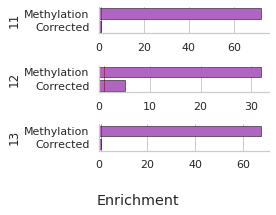

In [ ]:
sns.set(style="whitegrid", 
palette=sns.dark_palette("orange", reverse=True), 
rc={'figure.figsize':(4,3), 
    "axes.spines.right": False, 
    "axes.spines.top": False, 
    'font.size': 12})

my_pal = {"ins":"purple", "dels":"orange", "subs":"magenta"}
fig, ax = plt.subplots(nrows=3)
for idx, kmer in enumerate([11,12,13]):
    g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
                    y="variable",
                    x="value", color="mediumorchid",
                    linewidth=0.5, edgecolor='black',
                    ax = ax[idx])
    g.set_ylabel(f"{kmer}")
    g.set_xlabel("")
    g.axvline(1, color="maroon", lw=0.5)
fig.supxlabel("Enrichment")
plt.tight_layout()
plt.show()
plt.close()

### Plot ins/dels/subs

ENCFF441OSB


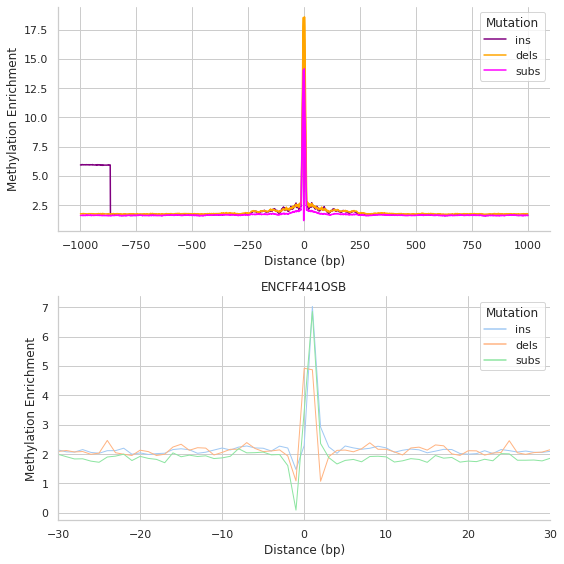

ENCFF865OXJ


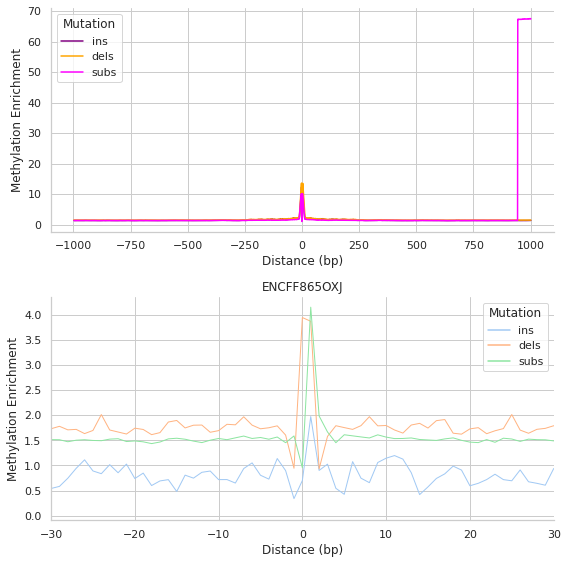

ENCFF896GOF


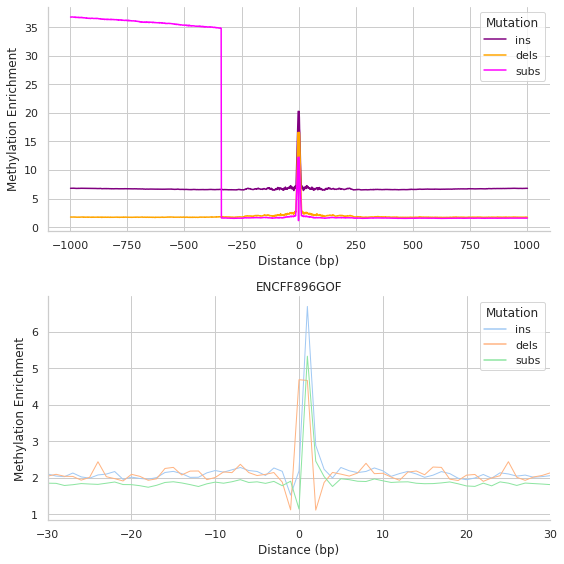

ENCFF524MTO


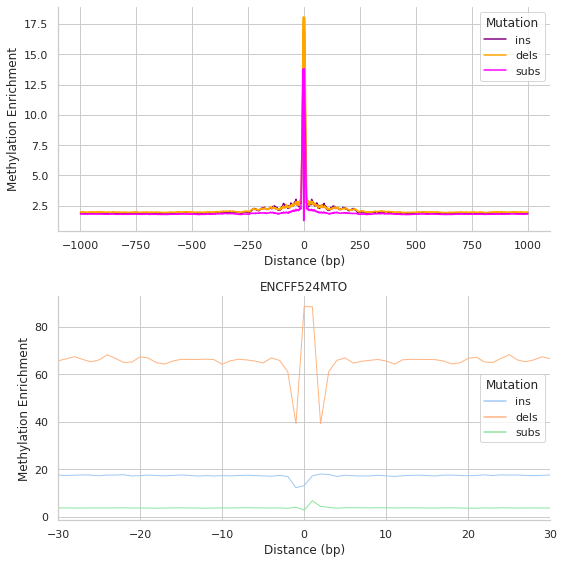

ENCFF283YAZ


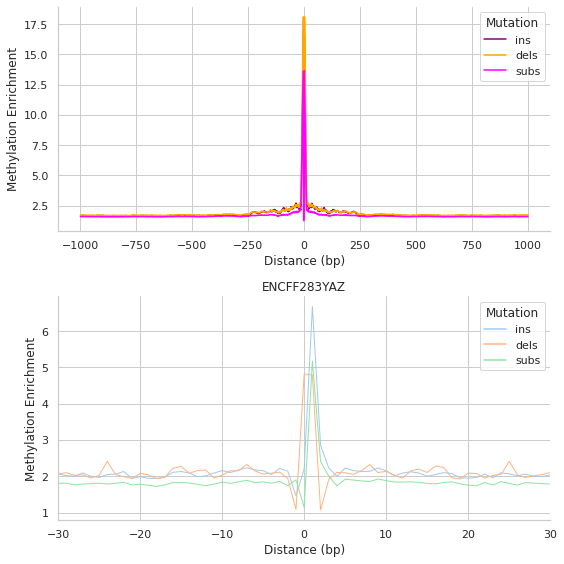

In [ ]:
muts = ['ins','dels','subs']
celltypes = ['ENCFF441OSB', 'ENCFF865OXJ', 'ENCFF896GOF', 'ENCFF524MTO', 'ENCFF283YAZ']

kmer = 13
all_df = pd.DataFrame()
for cell in celltypes:
    for mut in muts:
        numfile = f"wgbs/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell}.bedGraph.list.out.num"
        sumfile = f"wgbs/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell}.bedGraph.list.out.sum"
        # print(numfile,sumfile)
        numD = numsumfile_reader(numfile)
        sumD = numsumfile_reader(sumfile)
        assert numD != sumD, "Num and Sum are same"
        combined = {}
        bins = numD.keys()
        for k,v in numD.items(): #k is the bin number, v is the num Score
            score = (sumD[k])/v # sum Score / num Score
            combined[k] = score
        data=pd.DataFrame({"Distance (bp)":bins, 
                           "Cell Type": cell, 
                           "Methylation Enrichment":list(combined.values()),
                           "Mutation":mut,
                           "DataType":"Real"})
        all_df = pd.concat([all_df, data])
    ### REPEAT FOR CONTROLS
        numfile = f"wgbs/mutations_{kmer}bp_nulls_controls_{mut}.bed.score.{cell}.bedGraph.list.out.num"
        sumfile = f"wgbs/mutations_{kmer}bp_nulls_controls_{mut}.bed.score.{cell}.bedGraph.list.out.sum"
        # print(numfile,sumfile)
        numD = numsumfile_reader(numfile)
        sumD = numsumfile_reader(sumfile)
        assert numD != sumD, "Num and Sum are same"
        combined = {}
        for k,v in numD.items(): #k is the bin number, v is the num Score
            score = (sumD[k])/v # sum Score / num Score
            combined[k] = score
        data=pd.DataFrame({"Distance (bp)":bins, 
                           "Cell Type": cell, 
                           "Methylation Enrichment":list(combined.values()),
                           "Mutation":mut,
                           "DataType":"Control"})
        all_df = pd.concat([all_df, data])
all_df["Distance (bp)"] = all_df["Distance (bp)"] + 2

colors = ["#9DBCAC", "#F28963", "#4C797B", "#CB544B", "#BD45BF"]
#### Plot
sns.set(style="whitegrid", 
    palette="pastel", 
    rc={'figure.figsize':(8,8), 
        "axes.spines.right": False, 
        "axes.spines.top": False, 
        'font.size': 12})

for cell in celltypes:
    print(cell)
    my_pal = {"ins":"purple", "dels":"orange", "subs":"magenta"}
    fig, ax = plt.subplots(nrows=2)

    g = sns.lineplot(x = 'Distance (bp)', 
                     y = 'Methylation Enrichment', 
                     hue="Mutation", 
                     data=all_df[(all_df['DataType']=="Real") & (all_df['Cell Type']==cell)].reset_index(),
                     errorbar=None,
                     ax=ax[0],
                     palette=my_pal
                    )

    g = sns.lineplot(x = 'Distance (bp)', 
                     y = 'Methylation Enrichment', 
                     hue = "Mutation",
                     data=all_df[(all_df['DataType']=="Control") & (all_df['Cell Type']==cell)].reset_index(),
                     color='grey', lw=1,
                     errorbar=None, 
                     ax=ax[1])
    plt.title(f"{cell}")
    plt.xlim(-30,30)
    plt.tight_layout()
    plt.show()
    plt.close()

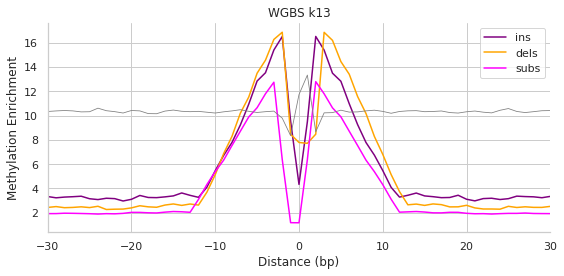

In [ ]:
muts = ['ins','dels','subs']

kmer = 13
all_df = pd.DataFrame()
for cell in celltypes:
    for mut in muts:
        numfile = f"wgbs/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell}.bedGraph.list.out.num"
        sumfile = f"wgbs/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell}.bedGraph.list.out.sum"
        # print(numfile,sumfile)
        numD = numsumfile_reader(numfile)
        sumD = numsumfile_reader(sumfile)
        assert numD != sumD, "Num and Sum are same"
        combined = {}
        bins = numD.keys()
        for k,v in numD.items(): #k is the bin number, v is the num Score
            score = (sumD[k])/v # sum Score / num Score
            combined[k] = score
        data=pd.DataFrame({"Distance (bp)":bins, 
                           "Cell Type": cell, 
                           "Methylation Enrichment":list(combined.values()),
                           "Mutation":mut,
                           "DataType":"Real"})
        all_df = pd.concat([all_df, data])
    ### REPEAT FOR CONTROLS
        numfile = f"wgbs/mutations_{kmer}bp_nulls_controls_{mut}.bed.score.{cell}.bedGraph.list.out.num"
        sumfile = f"wgbs/mutations_{kmer}bp_nulls_controls_{mut}.bed.score.{cell}.bedGraph.list.out.sum"
        # print(numfile,sumfile)
        numD = numsumfile_reader(numfile)
        sumD = numsumfile_reader(sumfile)
        assert numD != sumD, "Num and Sum are same"
        combined = {}
        for k,v in numD.items(): #k is the bin number, v is the num Score
            score = (sumD[k])/v # sum Score / num Score
            combined[k] = score
        data=pd.DataFrame({"Distance (bp)":bins, 
                           "Cell Type": cell, 
                           "Methylation Enrichment":list(combined.values()),
                           "Mutation":mut,
                           "DataType":"Control"})
        all_df = pd.concat([all_df, data])
all_df["Distance (bp)"] = all_df["Distance (bp)"] + 2

colors = ["#9DBCAC", "#F28963", "#4C797B", "#CB544B", "#BD45BF"]
#### Plot
sns.set(style="whitegrid", 
    palette="pastel", 
    rc={'figure.figsize':(8,4), 
        "axes.spines.right": False, 
        "axes.spines.top": False, 
        'font.size': 12})

my_pal = {"ins":"purple", "dels":"orange", "subs":"magenta"}
fig, ax = plt.subplots()
g = sns.lineplot(x = 'Distance (bp)', 
                 y = 'Methylation Enrichment', 
                 hue="Mutation", 
                 data=all_df[all_df['DataType']=="Real"].reset_index(),
                 errorbar=None,
                 ax=ax,
                 palette=my_pal
                )
g = sns.lineplot(x = 'Distance (bp)', 
                 y = 'Methylation Enrichment', 
                 data=all_df[all_df['DataType']=="Control"].reset_index(),
                 color='grey', lw=0.8,
                 errorbar=None, 
                 ax=ax)
plt.title(f"WGBS k{kmer}")
# outname = f.split("_hg38")[0]
plt.xlim(-30,30)
# plt.savefig(f"figs/{outname}.png")
plt.tight_layout()
plt.show()
plt.close()

#### Plot 11/12/13

In [ ]:
#### Need to add up each mutation type because all files are too big!!!!!!!
muts = ['ins','dels','subs']

all_df = pd.DataFrame()
for kmer in [11,12, 13]:
    for cell in celltypes:
        for mut in muts:
            numfile = f"wgbs/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell}.bedGraph.list.out.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_{mut}.bed.score.{cell}.bedGraph.list.out.sum"
            # print(numfile,sumfile)
            numD = numsumfile_reader(numfile)
            sumD = numsumfile_reader(sumfile)
            bins = numD.keys()
            assert numD != sumD, "Num and Sum are same"
            combined = {}
            for k,v in numD.items(): #k is the bin number, v is the num Score
                score = (sumD[k])/(v) # sum Score / num Score
                combined[k] = score
            data=pd.DataFrame({"Distance (bp)":bins, 
                           "Cell Type": cell, 
                           "Methylation Enrichment":list(combined.values()),
                           "DataType":"Real", "mut":mut,
                           "kmer":kmer})
            all_df = pd.concat([all_df, data])
            ### REPEAT FOR CONTROLS
            numfile = f"wgbs/mutations_{kmer}bp_nulls_controls_{mut}.bed.score.{cell}.bedGraph.list.out.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_controls_{mut}.bed.score.{cell}.bedGraph.list.out.sum"
            # print(numfile,sumfile)
            numD = numsumfile_reader(numfile)
            sumD = numsumfile_reader(sumfile)
            assert numD != sumD, "Num and Sum are same"
            combined = {}
            for k,v in numD.items(): #k is the bin number, v is the num Score
                try:
                    score = (sumD[k])/(v) # sum Score / num Score
                    combined[k] = score
                except:
                    combined[k] = 0
                    pass
            data=pd.DataFrame({"Distance (bp)":bins, 
                               "Cell Type": cell, 
                               "Methylation Enrichment":list(combined.values()), 
                               "DataType":"Control", "mut":mut,
                               "kmer":kmer})
            all_df = pd.concat([all_df, data])
all_df["Distance (bp)"] = all_df["Distance (bp)"] + 2

all_df.head(3)

,Distance (bp),Cell Type,Methylation Enrichment,DataType,mut,kmer
0,-998,ENCFF441OSB,1.577124,Real,ins,11
1,-997,ENCFF441OSB,1.945624,Real,ins,11
2,-996,ENCFF441OSB,1.477374,Real,ins,11


In [ ]:
combined_df = pd.DataFrame()
for kmer in [11,12, 13]:
    for mut in muts:
        subdf = all_df[(all_df.kmer == kmer) & (all_df.mut == mut)]
        enrich = subdf[(subdf.DataType == "Real")]['Methylation Enrichment'].max()
        ctrl_enrich = subdf[(subdf.DataType == "Control")]['Methylation Enrichment'].max()
        corr = enrich/ctrl_enrich
        df = pd.DataFrame([[enrich, corr]], columns=['Methylation','Corrected'])
        df['kmer']=kmer
        df['Mutation']=mut
        combined_df = pd.concat([combined_df, df])
combined_df

,Methylation,Corrected,kmer,Mutation
0,72.192251,0.721923,11,ins
0,68.178184,22.675363,11,dels
0,45.371348,0.453713,11,subs
0,31.440829,6.538043,12,ins
0,31.962704,14.977380,12,dels
0,27.034856,4.270719,12,subs
0,20.280677,1.101536,13,ins
0,18.593344,0.209922,13,dels
0,67.559319,1.219927,13,subs


In [ ]:
plot_df = pd.melt(combined_df, id_vars=['Mutation', 'kmer'], value_vars=['Methylation','Corrected'])
plot_df

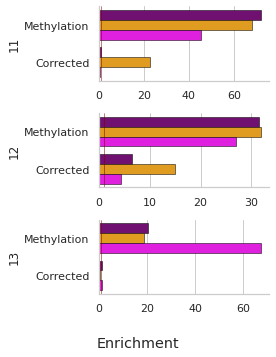

In [ ]:
sns.set(style="whitegrid", 
palette=sns.dark_palette("orange", reverse=True), 
rc={'figure.figsize':(4,5), 
    "axes.spines.right": False, 
    "axes.spines.top": False, 
    'font.size': 12})

my_pal = {"ins":"purple", "dels":"orange", "subs":"magenta"}
fig, ax = plt.subplots(nrows=3)
for idx, kmer in enumerate([11,12,13]):
    g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
                    y="variable",
                    x="value",
                    hue="Mutation",
                    palette=my_pal, linewidth=0.5, edgecolor='black',
                    ax = ax[idx])
    g.set_ylabel(f"{kmer}")
    g.set_xlabel("")
    g.legend_.remove()
    g.axvline(1, color="maroon", lw=0.5)
fig.supxlabel("Enrichment")
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
my_pal = {"ins":"purple", "dels":"orange", "subs":"magenta"}

#### Plot
sns.set(style="whitegrid", 
    palette="muted", 
    rc={'figure.figsize':(5,3), 
        "axes.spines.right": False, 
        "axes.spines.top": False, 
        'font.size': 12})

fig, axs = plt.subplots(ncols=2)
for idx, kmer in enumerate([11,12]):
    subdf = all_df[all_df.kmer==kmer]
    g = sns.lineplot(x = 'Distance (bp)', 
                     y = 'Methylation Enrichment', 
                     hue="mut", 
                     data=subdf[subdf['DataType']=="Real"].reset_index(),
                     errorbar=None,
                     ax=axs[idx],
                     palette=my_pal)
    g = sns.lineplot(x = 'Distance (bp)', 
                     y = 'Methylation Enrichment', 
                     # hue="Cell Type", 
                     data=subdf[subdf['DataType']=="Control"].reset_index(),
                     color='grey',
                     errorbar=None,
                     ax=axs[idx])
    g.legend_.remove()
    g.set_title(f"WGBS k{kmer}")
    g.set(ylabel='', xlabel='')    
plt.xlim(-30,30)
fig.supylabel(f'Enrichment')
fig.supxlabel('Distance from Mutation (bp)')
plt.tight_layout()
# outname = f.split("_hg38")[0]
# plt.savefig(f"figs/{outname}.png")
plt.show()
plt.close()

### Plot for each subs type

In [ ]:
celltypes = ['ENCFF441OSB', 'ENCFF865OXJ', 'ENCFF896GOF', 'ENCFF524MTO', 'ENCFF283YAZ']

### TROUBLESHOOT

In [ ]:
all_df = pd.DataFrame()
for kmer in [13]:
    for cell in celltypes:
        for mut in sigs.keys():
            refsub = mut[0]
            altsub = mut[1]
            numfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            ### Build bins dictionary
            numD = numsumfile_reader(numfile)
            bins = numD.keys()
            ### Repeat for equivalent
            equiv_ref, equiv_sub = equiv_sigs[(refsub, altsub)]
            equiv_numfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.num"
            equiv_sumfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            for group in [(numfile, sumfile), (equiv_numfile, equiv_sumfile)]:
                combined = {k:0 for k in bins}
                ### Build ref/alt dictionary ###
                numD = numsumfile_reader(group[0])
                sumD = numsumfile_reader(group[1])
                bins = numD.keys()
                if numD == sumD:
                    print(f"Num and Sum are same {group[0]} and \n {group[1]}")
                for k,v in numD.items():
                    try:
                        score = (sumD[k])/v # sum Score / num Score
                    except ZeroDivisionError:
                        score = 0
                    combined[k] += score
                combined_mean = sum(list(combined.values())) / len(combined.values())
                if combined_mean > 10:
                    print(cell, group, combined_mean)

ENCFF441OSB ('wgbs/mutations_13bp_nulls_subs_C_to_G.bed.score.ENCFF441OSB.bedGraph.list.ouut.num', 'wgbs/mutations_13bp_nulls_subs_C_to_G.bed.score.ENCFF441OSB.bedGraph.list.ouut.sum') 180.57820718673804
ENCFF441OSB ('wgbs/mutations_13bp_nulls_subs_T_to_G.bed.score.ENCFF441OSB.bedGraph.list.ouut.num', 'wgbs/mutations_13bp_nulls_subs_T_to_G.bed.score.ENCFF441OSB.bedGraph.list.ouut.sum') 4194.237231608151
Num and Sum are same wgbs/mutations_13bp_nulls_subs_C_to_A.bed.score.ENCFF865OXJ.bedGraph.list.ouut.num and 
 wgbs/mutations_13bp_nulls_subs_C_to_A.bed.score.ENCFF865OXJ.bedGraph.list.ouut.sum
ENCFF865OXJ ('wgbs/mutations_13bp_nulls_subs_C_to_G.bed.score.ENCFF865OXJ.bedGraph.list.ouut.num', 'wgbs/mutations_13bp_nulls_subs_C_to_G.bed.score.ENCFF865OXJ.bedGraph.list.ouut.sum') 54.37917190179247
ENCFF865OXJ ('wgbs/mutations_13bp_nulls_subs_A_to_G.bed.score.ENCFF865OXJ.bedGraph.list.ouut.num', 'wgbs/mutations_13bp_nulls_subs_A_to_G.bed.score.ENCFF865OXJ.bedGraph.list.ouut.sum') 119103.34066

In [ ]:
all_df = pd.DataFrame()
for kmer in [11,12,13]:
    for cell in celltypes:
        for mut in sigs.keys():
            refsub = mut[0]
            altsub = mut[1]
            numfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            ### Build bins dictionary
            numD = numsumfile_reader(numfile)
            bins = numD.keys()
            ### Repeat for equivalent
            equiv_ref, equiv_sub = equiv_sigs[(refsub, altsub)]
            equiv_numfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.num"
            equiv_sumfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            combined = {k:0 for k in bins}
            for group in [(numfile, sumfile), (equiv_numfile, equiv_sumfile)]:
                ### Build ref/alt dictionary ###
                numD = numsumfile_reader(group[0])
                sumD = numsumfile_reader(group[1])
                bins = numD.keys()
                if numD == sumD:
                    print(f"Num and Sum are same {group[0]} and \n {group[1]}")
                for k,v in numD.items():
                    try:
                        score = (sumD[k])/v # sum Score / num Score
                    except ZeroDivisionError:
                        score = 0
                    combined[k] += score
            combined_mean = sum(list(combined.values())) / len(combined.values())
            enriched_mean = [i/combined_mean for i in combined.values()]
            
            subs_type = f"{refsub}>{altsub}"

            data=pd.DataFrame({"bins":bins, 
                               "Density":list(combined.values()), 
                               "Cell":cell, 
                               "Mutation":subs_type, 
                               "kmer":kmer})
            melted = pd.melt(data, id_vars=['bins', 'Cell', 'Mutation', 'kmer'], value_vars=['Density'])
            all_df = pd.concat([all_df,melted])
all_df = all_df.reset_index(drop=True)
combined_df = pd.DataFrame()
for kmer in [11,12,13]:
    # for cell in celltypes:
    for mut in sigs.values():
        subdf = all_df[(all_df.kmer == kmer) & (all_df.Mutation == mut)]#  & (all_df.Cell == cell)]
        enriched_max = subdf['value'].max()
        df = pd.DataFrame([[enriched_max]], columns=['Density'])
        df['kmer']=kmer
        df['Mutation']=mut
        # df['Cell'] = cell
        combined_df = pd.concat([combined_df, df])
combined_df

In [ ]:
all_df = pd.DataFrame()
for kmer in [11,12,13]:
    for cell in celltypes:
        for mut in sigs.keys():
            refsub = mut[0]
            altsub = mut[1]
            numfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            ### Build bins dictionary
            numD = numsumfile_reader(numfile)
            bins = numD.keys()
            ### Repeat for equivalent
            equiv_ref, equiv_sub = equiv_sigs[(refsub, altsub)]
            equiv_numfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.num"
            equiv_sumfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            combined = {k:0 for k in bins}
            for group in [(numfile, sumfile), (equiv_numfile, equiv_sumfile)]:
                ### Build ref/alt dictionary ###
                numD = numsumfile_reader(group[0])
                sumD = numsumfile_reader(group[1])
                bins = numD.keys()
                if numD == sumD:
                    print(f"Num and Sum are same {group[0]} and \n {group[1]}")
                for k,v in numD.items():
                    try:
                        score = (sumD[k])/v # sum Score / num Score
                    except ZeroDivisionError:
                        score = 0
                    combined[k] += score
            combined_mean = sum(list(combined.values())) / len(combined.values())
            enriched_mean = [i/combined_mean for i in combined.values()]
            
            subs_type = f"{refsub}>{altsub}"

            data=pd.DataFrame({"bins":bins, 
                               "Density":list(combined.values()), 
                               "Cell":cell, 
                               "Mutation":subs_type, 
                               "kmer":kmer})
            melted = pd.melt(data, id_vars=['bins', 'Cell', 'Mutation', 'kmer'], value_vars=['Density'])
            all_df = pd.concat([all_df,melted])
all_df = all_df.reset_index(drop=True)
combined_df = pd.DataFrame()
for kmer in [11,12,13]:
    for cell in celltypes:
        for mut in sigs.values():
            subdf = all_df[(all_df.kmer == kmer) & (all_df.Mutation == mut) & (all_df.Cell == cell)]
            enriched_max = subdf['value'].max()
            df = pd.DataFrame([[enriched_max]], columns=['Density'])
            df['kmer']=kmer
            df['Mutation']=mut
            df['Cell'] = cell
            combined_df = pd.concat([combined_df, df])
combined_df

Num and Sum are same wgbs/mutations_13bp_nulls_subs_C_to_A.bed.score.ENCFF865OXJ.bedGraph.list.ouut.num and 
 wgbs/mutations_13bp_nulls_subs_C_to_A.bed.score.ENCFF865OXJ.bedGraph.list.ouut.sum


,Density,kmer,Mutation,Cell
0,80.908851,11,C>A,ENCFF441OSB
0,95.096854,11,C>G,ENCFF441OSB
0,77.887364,11,C>T,ENCFF441OSB
0,86.507937,11,T>A,ENCFF441OSB
0,113.659161,11,T>C,ENCFF441OSB
...,...,...,...,...
0,134.475458,13,C>G,ENCFF283YAZ
0,54.174176,13,C>T,ENCFF283YAZ
0,41.268377,13,T>A,ENCFF283YAZ
0,315724.417411,13,T>C,ENCFF283YAZ


In [ ]:
combined_df.sort_values(by="Density").to_csv("wgbs.txt", index=None)

In [ ]:
all_df = pd.DataFrame()
for kmer in [11,12,13]:
    for cell in celltypes:
        for mut in sigs.keys():
            refsub = mut[0]
            altsub = mut[1]
            numfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            ### Build bins dictionary
            numD = numsumfile_reader(numfile)
            bins = numD.keys()
            ### Repeat for equivalent
            equiv_ref, equiv_sub = equiv_sigs[(refsub, altsub)]
            equiv_numfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.num"
            equiv_sumfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            combined = {k:0 for k in bins}
            for group in [(numfile, sumfile), (equiv_numfile, equiv_sumfile)]:
                ### Build ref/alt dictionary ###
                numD = numsumfile_reader(group[0])
                sumD = numsumfile_reader(group[1])
                bins = numD.keys()
                if numD == sumD:
                    print(f"Num and Sum are same {group[0]} and \n {group[1]}")
                for k,v in numD.items():
                    try:
                        score = (sumD[k])/v # sum Score / num Score
                    except ZeroDivisionError:
                        score = 0
                    combined[k] += score
            combined_mean = sum(list(combined.values())) / len(combined.values())
            enriched_mean = [i/combined_mean for i in combined.values()]
            
            subs_type = f"{refsub}>{altsub}"

            data=pd.DataFrame({"bins":bins, 
                               "Density":list(combined.values()), 
                               "Cell":cell, 
                               "Mutation":subs_type, 
                               "kmer":kmer})
            melted = pd.melt(data, id_vars=['bins', 'Cell', 'Mutation', 'kmer'], value_vars=['Density'])
            all_df = pd.concat([all_df,melted])
all_df = all_df.reset_index(drop=True)
combined_df = pd.DataFrame()
for kmer in [11,12,13]:
    # for cell in celltypes:
    for mut in sigs.values():
        subdf = all_df[(all_df.kmer == kmer) & (all_df.Mutation == mut)]#  & (all_df.Cell == cell)]
        enriched_max = subdf['value'].max()
        df = pd.DataFrame([[enriched_max]], columns=['Density'])
        df['kmer']=kmer
        df['Mutation']=mut
        # df['Cell'] = cell
        combined_df = pd.concat([combined_df, df])
combined_df

Num and Sum are same wgbs/mutations_13bp_nulls_subs_C_to_A.bed.score.ENCFF865OXJ.bedGraph.list.ouut.num and 
 wgbs/mutations_13bp_nulls_subs_C_to_A.bed.score.ENCFF865OXJ.bedGraph.list.ouut.sum


,Density,kmer,Mutation
0,8.531214e+01,11,C>A
0,1.547619e+02,11,C>G
0,1.021505e+02,11,C>T
0,8.851274e+01,11,T>A
0,1.136592e+02,11,T>C
0,1.068019e+02,11,T>G
0,7.105883e+01,12,C>A
0,5.383744e+01,12,C>G
0,7.014754e+01,12,C>T
0,6.237973e+01,12,T>A


In [ ]:
all_df

,bins,Cell,Mutation,kmer,variable,value
0,-1000,ENCFF441OSB,C>A,11,Density,0.990099
1,-999,ENCFF441OSB,C>A,11,Density,1.010101
2,-998,ENCFF441OSB,C>A,11,Density,5.218750
3,-997,ENCFF441OSB,C>A,11,Density,6.684982
4,-996,ENCFF441OSB,C>A,11,Density,7.298513
...,...,...,...,...,...,...
179995,995,ENCFF283YAZ,T>G,13,Density,2.948173
179996,996,ENCFF283YAZ,T>G,13,Density,2.948129
179997,997,ENCFF283YAZ,T>G,13,Density,2.941769
179998,998,ENCFF283YAZ,T>G,13,Density,2.935061


In [ ]:
# all_df = pd.DataFrame()
# for kmer in [11,12,13]:
#     for cell in celltypes:
#         for mut in sigs.keys():
#             refsub = mut[0]
#             altsub = mut[1]
#             numfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.num"
#             sumfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.sum"
#             ### Build num dictionary
#             numD = numsumfile_reader(numfile)
#             ### Build sum dictionary
#             sumD = numsumfile_reader(sumfile)
#             bins = numD.keys()
#             # assert numD != sumD, "Num and Sum are same"
#             combined = {k:0 for k in bins}
#             for k,v in numD.items(): #k is the bin number, v is the num Score
#                 try:
#                     score = (sumD[k])/v # sum Score / num Score
#                 except:
#                     score = 0 
#                 combined[k] += score 
                       
#             ### Repeat for equivalent
#             equiv_ref, equiv_sub = equiv_sigs[(refsub, altsub)]
#             numfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.num"
#             sumfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.sum"
#            ### Build num dictionary
#             numD = numsumfile_reader(numfile)
#             ### Build sum dictionary
#             sumD = numsumfile_reader(sumfile)
#             # assert numD != sumD, "Num and Sum are same"
#             if numD == sumD:
#                 print(numfile, sumfile)
#             for k,v in numD.items(): #k is the bin number, v is the num Score
#                 try:
#                     score = (sumD[k])/v # sum Score / num Score
#                 except:
#                     score = 0 
#                 combined[k] += score 
#             subs_type = f"{refsub}>{altsub}"
            
#             ### REPEAT FOR CONTROLS ###
#             numfile = f"wgbs/mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.num"
#             sumfile = f"wgbs/mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.sum"
#             ### Build num dictionary
#             numD = numsumfile_reader(numfile)
#             ### Build sum dictionary
#             sumD = numsumfile_reader(sumfile)
#             bins = numD.keys()
#             # assert numD != sumD, "Num and Sum are same"
#             if numD == sumD:
#                 print(numfile, sumfile)
#             combined = {k:0 for k in bins}
#             for k,v in numD.items(): #k is the bin number, v is the num Score
#                 try:
#                     score = (sumD[k])/v # sum Score / num Score
#                 except:
#                     score = 0 
#                 combined[k] += score 
            
#             numfile = f"wgbs/mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.num"
#             sumfile = f"wgbs/mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.sum"
          
            
            
#             data=pd.DataFrame({"bins":bins, 
#                                "Density":list(combined.values()), 
#                                "Cell":cell, 
#                                "Mutation":subs_type, 
#                                "kmer":kmer})
#             melted = pd.melt(data, id_vars=['bins', 'Cell', 'Mutation', 'kmer'], value_vars=['Density'])
#             all_df = pd.concat([all_df,melted])
# all_df = all_df.reset_index(drop=True)
# all_df.head(3)

wgbs/mutations_13bp_nulls_subs_C_to_A.bed.score.ENCFF865OXJ.bedGraph.list.ouut.num wgbs/mutations_13bp_nulls_subs_C_to_A.bed.score.ENCFF865OXJ.bedGraph.list.ouut.sum


,bins,Cell,Mutation,kmer,variable,value
0,-1000,ENCFF441OSB,C>A,11,Density,0.826446
1,-999,ENCFF441OSB,C>A,11,Density,3.478261
2,-998,ENCFF441OSB,C>A,11,Density,2.752294


In [ ]:
all_df = pd.DataFrame()
for kmer in [11,12,13]:
    for cell in celltypes:
        for mut in sigs.keys():
            refsub = mut[0]
            altsub = mut[1]
            numfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.num"
            sumfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            ### Build bins dictionary
            numD = numsumfile_reader(numfile)
            bins = numD.keys()
            ### Repeat for equivalent
            equiv_ref, equiv_sub = equiv_sigs[(refsub, altsub)]
            equiv_numfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.num"
            equiv_sumfile = f"wgbs/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.{cell}.bedGraph.list.ouut.sum"
            combined = {k:0 for k in bins}
            for group in [(numfile, sumfile), (equiv_numfile, equiv_sumfile)]:
                ### Build ref/alt dictionary ###
                numD = numsumfile_reader(group[0])
                sumD = numsumfile_reader(group[1])
                bins = numD.keys()
                if numD == sumD:
                    print(f"Num and Sum are same {group[0]} and \n {group[1]}")
                for k,v in numD.items():
                    try:
                        score = (sumD[k])/v # sum Score / num Score
                    except ZeroDivisionError:
                        score = 0
                    combined[k] += score
            combined_mean = sum(list(combined.values())) / len(combined.values())
            enriched_mean = [i/combined_mean for i in combined.values()]
            
            subs_type = f"{refsub}>{altsub}"

            data=pd.DataFrame({"bins":bins, 
                               "Density":list(combined.values()), 
                               "Cell":cell, 
                               "Mutation":subs_type, 
                               "kmer":kmer})
            melted = pd.melt(data, id_vars=['bins', 'Cell', 'Mutation', 'kmer'], value_vars=['Density'])
            all_df = pd.concat([all_df,melted])
all_df = all_df.reset_index(drop=True)
combined_df = pd.DataFrame()
for kmer in [11,12,13]:
    # for cell in celltypes:
    for mut in sigs.values():
        subdf = all_df[(all_df.kmer == kmer) & (all_df.Mutation == mut)]#  & (all_df.Cell == cell)]
        enriched_max = subdf['value'].max()
        df = pd.DataFrame([[enriched_max]], columns=['Density'])
        df['kmer']=kmer
        df['Mutation']=mut
        # df['Cell'] = cell
        combined_df = pd.concat([combined_df, df])
combined_df

Num and Sum are same wgbs/mutations_13bp_nulls_subs_C_to_A.bed.score.ENCFF865OXJ.bedGraph.list.ouut.num and 
 wgbs/mutations_13bp_nulls_subs_C_to_A.bed.score.ENCFF865OXJ.bedGraph.list.ouut.sum


,Density,kmer,Mutation
0,8.531214e+01,11,C>A
0,1.547619e+02,11,C>G
0,1.021505e+02,11,C>T
0,8.851274e+01,11,T>A
0,1.136592e+02,11,T>C
0,1.068019e+02,11,T>G
0,7.105883e+01,12,C>A
0,5.383744e+01,12,C>G
0,7.014754e+01,12,C>T
0,6.237973e+01,12,T>A


In [ ]:
combined_df = pd.DataFrame()
for kmer in [11,12,13]:
    # for cell in celltypes:
    for mut in sigs.values():
        subdf = all_df[(all_df.kmer == kmer) & (all_df.Mutation == mut)]#  & (all_df.Cell == cell)]
        enriched_max = subdf['value'].max()
        df = pd.DataFrame([[enriched_max]], columns=['Density'])
        df['kmer']=kmer
        df['Mutation']=mut
        # df['Cell'] = cell
        combined_df = pd.concat([combined_df, df])
combined_df

,Density,kmer,Mutation
0,7.812500e+00,11,C>A
0,6.070288e+00,11,C>G
0,1.044444e+01,11,C>T
0,9.905938e+00,11,T>A
0,5.460751e+00,11,T>C
0,5.166052e+00,11,T>G
0,2.641938e+00,12,C>A
0,2.248765e+00,12,C>G
0,2.774113e+00,12,C>T
0,2.541762e+00,12,T>A


In [ ]:
plot_df = pd.melt(combined_df, id_vars=['Mutation', 'kmer'], value_vars=['Density'])
plot_df

,Mutation,kmer,variable,value
0,C>A,11,Density,8.531214e+01
1,C>G,11,Density,1.547619e+02
2,C>T,11,Density,1.021505e+02
3,T>A,11,Density,8.851274e+01
4,T>C,11,Density,1.136592e+02
5,T>G,11,Density,1.068019e+02
6,C>A,12,Density,7.105883e+01
7,C>G,12,Density,5.383744e+01
8,C>T,12,Density,7.014754e+01
9,T>A,12,Density,6.237973e+01


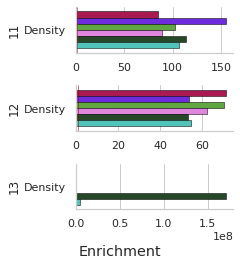

In [ ]:
sns.set(style="whitegrid",
# palette=sns.dark_palette("orange", reverse=True), 
rc={'figure.figsize':(3.5,4), 
    "axes.spines.right": False, 
    "axes.spines.top": False, 
    'font.size': 12})

fig, ax = plt.subplots(nrows=3)
for idx, kmer in enumerate([11,12,13]):
    g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
                    y="variable",
                    x="value",
                    hue="Mutation",
                    palette=subsD, linewidth=0.5, edgecolor='black',
                    ax = ax[idx])
    g.set_ylabel(f"{kmer}")
    g.set_xlabel("")
    # g.set_yticklabels("")
    g.legend_.remove()
    g.axvline(1, color="maroon", lw=0.5)
fig.supxlabel("Enrichment", y=0.08)

plt.savefig("figs/wgbs/subs_k11-13.svg")
plt.savefig("figs/wgbs/subs_k11-13.png")
plt.tight_layout()
plt.show()
plt.close()

## Plot DnaseI

In [ ]:
cell_lines = ['UwGm12878', 'UwHuvec', 'UwHepg2', 'UwK562', 'UwNhek', 'UwMcf7']

### Filecheckers

In [ ]:
### THIS IS GOOD ###
for kmer in [11,12,13]:
    for cell in cell_lines:
        numfile = f"dnase/mutations_{kmer}bp_nulls.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.out.num"
        sumfile = f"dnase/mutations_{kmer}bp_nulls.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.out.sum"
        filechecker(numfile)
        filechecker(sumfile)

In [ ]:
### THIS IS GOOD ###
muts = ['ins','dels','subs']
for kmer in [11,12,13]:
    for mut in muts:
        for cell in cell_lines:
            numfile = f"dnase/mutations_{kmer}bp_nulls_{mut}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.out.num"
            sumfile = f"dnase/mutations_{kmer}bp_nulls_{mut}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.out.sum"
            filechecker(numfile)
            filechecker(sumfile)

In [ ]:
### THIS IS GOOD ###
for kmer in [11, 12, 13]:
    for cell in cell_lines:
        for sig in sigs:
            refsub, altsub = sig
            numfile = f"dnase/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.ouut.num"
            sumfile = f"dnase/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.ouut.sum"
            filechecker(numfile)
            filechecker(sumfile)
            equiv_ref, equiv_sub = equiv_sigs[(refsub, altsub)]
            numfile = f"dnase/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.ouut.num"
            sumfile = f"dnase/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.ouut.sum"
            filechecker(numfile)
            filechecker(sumfile)

### Plot All DONE

#### Plot all for 11/12/13 DONE

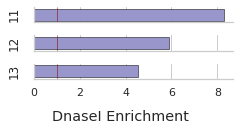

In [ ]:
# fig, axs = plt.subplots(ncols=2)
all_df = pd.DataFrame()
for idx, kmer in enumerate([11,12,13]):
    for cell in cell_lines:
        numfile = f"dnase/mutations_{kmer}bp_nulls.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.out.num"
        sumfile = f"dnase/mutations_{kmer}bp_nulls.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.out.sum"
        # print(numfile, sumfile)
        ### Build num dictionary
        df_numfile = pd.read_csv(numfile,sep="\t")
        bins=[int(i) for i in list(df_numfile.columns)][:-1]
        scores=list(df_numfile.iloc[0])[:-1]
        numD = dict(zip(bins, scores))
        ### Build sum dictionary
        df_sumfile = pd.read_csv(sumfile,sep="\t")
        bins=[int(i) for i in list(df_sumfile.columns)][:-1]
        scores=list(df_sumfile.iloc[0])[:-1]
        sumD = dict(zip(bins, scores))
        assert numD != sumD, "Num and Sum are same"
        combined = {}
        for k,v in numD.items(): #k is the bin number, v is the num Score
            score = (sumD[k])/v # sum Score / num Score
            combined[k] = score     
        data=pd.DataFrame({"Distance (bp)":bins, "DnaseI Density":list(combined.values()), "Cell":cell, "kmer":kmer})
        melted = pd.melt(data, id_vars=['Distance (bp)', 'Cell', 'kmer'], value_vars=['DnaseI Density'])
        all_df = pd.concat([all_df,melted])
    all_df = all_df.reset_index(drop=True)
    all_df["Distance (bp)"] = all_df["Distance (bp)"] + 2

combined_df = pd.DataFrame()
for kmer in [11,12,13]:
    subdf = all_df[(all_df.kmer == kmer)]
    enriched_max = subdf['value'].max()
    df = pd.DataFrame([[enriched_max]], columns=['DNase'])
    df['kmer']=kmer
    combined_df = pd.concat([combined_df, df])
plot_df = pd.melt(combined_df, id_vars=['kmer'], value_vars=['DNase'])
plot_df
    
sns.set(style="whitegrid", 
        palette=sns.light_palette("#918DD5", reverse=True), 
        rc={'figure.figsize':(3.5,2), 
            "axes.spines.right": False, 
            "axes.spines.top": False, 
            'font.size': 12})

fig, ax = plt.subplots(nrows=3, sharex=True)
for idx, kmer in enumerate([11,12,13]):
    g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
                    y="variable",
                    x="value",
                    linewidth=0.5, edgecolor='black',
                    ax = ax[idx])
    g.set_ylabel(f"{kmer}")
    g.set_xlabel("")
    g.set_yticklabels("")
    g.axvline(1, color="maroon", lw=0.5)
fig.supxlabel("DnaseI Enrichment", y=0.1)
plt.tight_layout()
# plt.savefig("figs/dnase/all_k11-13.svg")
# plt.savefig("figs/dnase/all_k11-13.png")
plt.show()
plt.close()

In [ ]:
### THIS IS TO MERGE IT WITH THE HISTONE HEATMAP
dnase_all = all_df
all_df

,Distance (bp),Cell,kmer,variable,value
0,-994,UwGm12878,11,DnaseI Density,1.601415
1,-993,UwGm12878,11,DnaseI Density,1.579370
2,-992,UwGm12878,11,DnaseI Density,1.602604
3,-991,UwGm12878,11,DnaseI Density,1.591874
4,-990,UwGm12878,11,DnaseI Density,1.598138
...,...,...,...,...,...
35995,997,UwMcf7,13,DnaseI Density,1.314975
35996,998,UwMcf7,13,DnaseI Density,1.314788
35997,999,UwMcf7,13,DnaseI Density,1.314649
35998,1000,UwMcf7,13,DnaseI Density,1.315536


### COPY TO FINAL

In [ ]:
cell_lines = ['UwGm12878', 'UwHuvec', 'UwHepg2', 'UwK562', 'UwNhek', 'UwMcf7']
analysis="dnase"

for kmer in [11,12,13]:
    for cell in cell_lines:
        numfile = f"{analysis}/mutations_{kmer}bp_nulls.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.out.num"
        sumfile = f"{analysis}/mutations_{kmer}bp_nulls.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.out.sum"
        for fn in [numfile, sumfile]:
            destination_path = f"FINAL/{fn}"
            # Create the destination directory if it doesn't exist
            destination_directory = os.path.dirname(destination_path)
            if not os.path.exists(destination_directory):
                os.makedirs(destination_directory)            
            # print(destination_path)
            shutil.copy2(fn, destination_path)

### Plot ins/dels/subs

In [ ]:
muts = ["ins", "dels", "subs"]

all_df = pd.DataFrame()
for kmer in [11,12,13]:
    for cell in cell_lines:
        for mut in muts:
            numfile = f"dnase/mutations_{kmer}bp_nulls_{mut}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.out.num"
            sumfile = f"dnase/mutations_{kmer}bp_nulls_{mut}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.out.sum"
            # print(numfile, sumfile)
            ### Build num dictionary
            numD = numsumfile_reader(numfile)
            ### Build sum dictionary
            sumD = numsumfile_reader(sumfile)
            bins = numD.keys()
            assert numD != sumD, "Num and Sum are same"
            combined = {}
            for k,v in numD.items(): #k is the bin number, v is the num Score
                score = (sumD[k])/v # sum Score / num Score
                combined[k] = score     
            data=pd.DataFrame({"bins":bins, 
                               "DnaseI Density":list(combined.values()), 
                               "Cell":cell, 
                               "Mutation":mut, 
                               "kmer":kmer})
            melted = pd.melt(data, id_vars=['bins', 'Cell', 'Mutation', 'kmer'], value_vars=['DnaseI Density'])
            all_df = pd.concat([all_df,melted])
all_df = all_df.reset_index(drop=True)
all_df.head(3)

,bins,Cell,Mutation,kmer,variable,value
0,-1000,UwGm12878,ins,11,DnaseI Density,1.497269
1,-999,UwGm12878,ins,11,DnaseI Density,1.514677
2,-998,UwGm12878,ins,11,DnaseI Density,1.498984


In [ ]:
combined_df = pd.DataFrame()
for kmer in [11,12,13]:
    for mut in muts:
        subdf = all_df[(all_df.kmer == kmer) & (all_df.Mutation == mut)]
        enriched_max = subdf['value'].max()
        df = pd.DataFrame([[enriched_max]], columns=['DNase'])
        df['kmer']=kmer
        df['Mutation']=mut
        combined_df = pd.concat([combined_df, df])
plot_df = pd.melt(combined_df, id_vars=['Mutation', 'kmer'], value_vars=['DNase'])
plot_df

,Mutation,kmer,variable,value
0,ins,11,DNase,7.563611
1,dels,11,DNase,9.297183
2,subs,11,DNase,9.281821
3,ins,12,DNase,5.672180
4,dels,12,DNase,7.779227
5,subs,12,DNase,5.830345
6,ins,13,DNase,4.278397
7,dels,13,DNase,5.703216
8,subs,13,DNase,4.316042


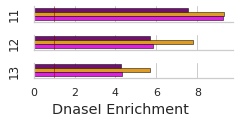

In [ ]:
sns.set(style="whitegrid", 
palette="pastel", 
rc={'figure.figsize':(3.5,2), 
    "axes.spines.right": False, 
    "axes.spines.top": False, 
    'font.size': 12})

my_pal = {"ins":"purple", "dels":"orange", "subs":"magenta"}
fig, ax = plt.subplots(nrows=3, sharex=True)
for idx, kmer in enumerate([11,12,13]):
    g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
                    y="variable",
                    x="value",
                    hue="Mutation",
                    palette=my_pal, linewidth=0.5, edgecolor='black',
                    ax = ax[idx])
    g.set_ylabel(f"{kmer}")
    g.set_xlabel("")
    g.set_yticklabels("")
    g.legend_.remove()
    g.axvline(1, color="maroon", lw=0.5)
fig.supxlabel("DnaseI Enrichment", y=0.15)
plt.tight_layout()
# plt.savefig("figs/dnase/muts_k11-13.svg")
# plt.savefig("figs/dnase/muts_k11-13.png")
plt.show()
plt.close()

#### Export legend

In [ ]:
# Create a color palette
import matplotlib.patches as mpatches
my_pal = {"Insertions":"purple", "Deletions":"orange", "Substitutions":"magenta"}

sns.set(style="whitegrid", 
palette=sns.dark_palette("#f47257", reverse=True), 
rc={'figure.figsize':(3,1), 
    "axes.spines.right": False, 
    "axes.spines.top": False, 
    'font.size': 12})

# Create legend handles manually
handles = [mpatches.Patch(color=my_pal[x], label=x) for x in my_pal.keys()]
# Create legend
plt.legend(handles=handles, ncol=3, frameon=False)
# Get current axes object and turn off axis
plt.gca().set_axis_off()
plt.tight_layout()
plt.show()
plt.close()

### COPY TO FINAL

In [ ]:
muts = ["ins", "dels", "subs"]
cell_lines = ['UwGm12878', 'UwHuvec', 'UwHepg2', 'UwK562', 'UwNhek', 'UwMcf7']
analysis="dnase"

for kmer in [11,12,13]:
    for cell in cell_lines:
        for mut in muts:
            numfile = f"{analysis}/mutations_{kmer}bp_nulls_{mut}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.out.num"
            sumfile = f"{analysis}/mutations_{kmer}bp_nulls_{mut}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.out.sum"
            for fn in [numfile, sumfile]:
                destination_path = f"FINAL/{fn}"
                # Create the destination directory if it doesn't exist
                destination_directory = os.path.dirname(destination_path)
                if not os.path.exists(destination_directory):
                    os.makedirs(destination_directory)            
                # print(destination_path)
                shutil.copy2(fn, destination_path)

### Plot for each subs type

In [ ]:
all_df = pd.DataFrame()
for kmer in [11,12,13]:
    for cell in cell_lines:
        for mut in sigs.keys():
            refsub = mut[0]
            altsub = mut[1]
            numfile = f"dnase/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.ouut.num"
            sumfile = f"dnase/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.ouut.sum"
            ### Build num dictionary
            numD = numsumfile_reader(numfile)
            ### Build sum dictionary
            sumD = numsumfile_reader(sumfile)
            bins = numD.keys()
            assert numD != sumD, "Num and Sum are same"
            combined = {k:0 for k in bins}
            for k,v in numD.items(): #k is the bin number, v is the num Score
                score = (sumD[k])/v # sum Score / num Score
                combined[k] += score
            ### Repeat for equivalent
            equiv_ref, equiv_sub = equiv_sigs[(refsub, altsub)]
            numfile = f"dnase/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.ouut.num"
            sumfile = f"dnase/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.ouut.sum"
            ### Build num dictionary
            numD = numsumfile_reader(numfile)
            ### Build sum dictionary
            sumD = numsumfile_reader(sumfile)
            assert numD != sumD, "Num and Sum are same"
            for k,v in numD.items(): #k is the bin number, v is the num Score
                score = (sumD[k])/v # sum Score / num Score
                combined[k] += score 

            subs_type = f"{refsub}>{altsub}"
            data=pd.DataFrame({"bins":bins, 
                               "DnaseI Density":list(combined.values()), 
                               "Cell":cell, 
                               "Mutation":subs_type, 
                               "kmer":kmer})
            melted = pd.melt(data, id_vars=['bins', 'Cell', 'Mutation', 'kmer'], value_vars=['DnaseI Density'])
            all_df = pd.concat([all_df,melted])
all_df = all_df.reset_index(drop=True)
all_df.head(3)

,bins,Cell,Mutation,kmer,variable,value
0,-1000,UwGm12878,C>A,11,DnaseI Density,6.299575
1,-999,UwGm12878,C>A,11,DnaseI Density,6.198265
2,-998,UwGm12878,C>A,11,DnaseI Density,6.244293


In [ ]:
combined_df = pd.DataFrame()
for kmer in [11,12,13]:
    for mut in sigs.values():
        subdf = all_df[(all_df.kmer == kmer) & (all_df.Mutation == mut)]
        enriched_max = subdf['value'].max()
        df = pd.DataFrame([[enriched_max]], columns=['DNase'])
        df['kmer']=kmer
        df['Mutation']=mut
        combined_df = pd.concat([combined_df, df])
combined_df

,DNase,kmer,Mutation
0,66.589904,11,C>A
0,13.580143,11,C>G
0,65.057807,11,C>T
0,41.564548,11,T>A
0,6.767994,11,T>C
0,23.143737,11,T>G
0,40.324076,12,C>A
0,9.564946,12,C>G
0,38.270248,12,C>T
0,21.082880,12,T>A


In [ ]:
plot_df = pd.melt(combined_df, id_vars=['Mutation', 'kmer'], value_vars=['DNase'])
plot_df

,Mutation,kmer,variable,value
0,C>A,11,DNase,66.589904
1,C>G,11,DNase,13.580143
2,C>T,11,DNase,65.057807
3,T>A,11,DNase,41.564548
4,T>C,11,DNase,6.767994
5,T>G,11,DNase,23.143737
6,C>A,12,DNase,40.324076
7,C>G,12,DNase,9.564946
8,C>T,12,DNase,38.270248
9,T>A,12,DNase,21.082880


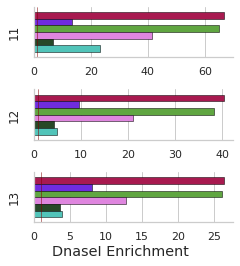

In [ ]:
sns.set(style="whitegrid",
# palette=sns.dark_palette("orange", reverse=True), 
rc={'figure.figsize':(3.5,4), 
    "axes.spines.right": False, 
    "axes.spines.top": False, 
    'font.size': 12})

fig, ax = plt.subplots(nrows=3)
for idx, kmer in enumerate([11,12,13]):
    g = sns.barplot(data = plot_df[plot_df['kmer']==kmer],
                    y="variable",
                    x="value",
                    hue="Mutation",
                    palette=subsD, linewidth=0.5, edgecolor='black',
                    ax = ax[idx])
    g.set_ylabel(f"{kmer}")
    g.set_xlabel("")
    g.set_yticklabels("")
    g.legend_.remove()
    g.axvline(1, color="maroon", lw=0.5)
fig.supxlabel("DnaseI Enrichment", y=0.08)
# plt.savefig("figs/dnase/subs_k11-13.svg")
# plt.savefig("figs/dnase/subs_k11-13.png")
plt.tight_layout()
plt.show()
plt.close()

### COPY TO FINAL

In [ ]:
cell_lines = ['UwGm12878', 'UwHuvec', 'UwHepg2', 'UwK562', 'UwNhek', 'UwMcf7']
analysis="dnase"

for kmer in [11,12,13]:
    for cell in cell_lines:
        for sig in sigs:
            refsub, altsub = sig
            equiv_sig = equiv_sigs[(refsub, altsub)]

            numfile = f"{analysis}/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.ouut.num"
            sumfile = f"{analysis}/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.ouut.sum"
            ## equivalent substitution
            equiv_numfile = f"{analysis}/mutations_{kmer}bp_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.ouut.num"
            equiv_sumfile = f"{analysis}/mutations_{kmer}bp_nulls_subs_{equiv_sig[0]}_to_{equiv_sig[1]}.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.ouut.sum"
 
            for fn in [numfile, sumfile, equiv_numfile, equiv_sumfile]:
                destination_path = f"FINAL/{fn}"
                # Create the destination directory if it doesn't exist
                destination_directory = os.path.dirname(destination_path)
                if not os.path.exists(destination_directory):
                    os.makedirs(destination_directory)            
                # print(destination_path)
                shutil.copy2(fn, destination_path)

## Plot Histones

In [ ]:
cell_lines = ['Nhlf', 'Huvec', 'K562', 'Nhek', 'H1hesc', 'Gm12878', 'Hsmm']
hist_mods = ['H3k27ac', 'H3k4me3', 'H3k4me1']

### Filecheckers

In [ ]:
### THIS IS GOOD ### 
for kmer in [11,12,13]:
    for cell in cell_lines:
        for hist in hist_mods:
            numfile = f"histones/mutations_{kmer}bp_nulls.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.out.num"
            sumfile = f"histones/mutations_{kmer}bp_nulls.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.out.sum"
            filechecker(numfile)
            filechecker(sumfile)

In [ ]:
### THIS IS GOOD ### 
muts = ["ins", "dels", "subs"]
for kmer in [11,12,13]:
    for cell in cell_lines:
        for hist in hist_mods:
            for mut in muts:
                numfile = f"histones/mutations_{kmer}bp_nulls_{mut}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.out.num"
                sumfile = f"histones/mutations_{kmer}bp_nulls_{mut}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.out.sum"
                filechecker(numfile)
                filechecker(sumfile)

In [ ]:
### THIS IS GOOD ###
for kmer in [11,12,13]:
    for cell in cell_lines:
        for hist in hist_mods:
            for sig in sigs:
                refsub, altsub = sig
                numfile = f"histones/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.ouut.num"
                sumfile = f"histones/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.ouut.sum"
                # print(numfile)
                # print(sumfile)
                filechecker(numfile)
                filechecker(sumfile)
                equiv_ref, equiv_sub = equiv_sigs[(refsub, altsub)]
                numfile = f"histones/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.ouut.num"
                sumfile = f"histones/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.ouut.sum"
                # print(numfile)
                # print(sumfile)
                filechecker(numfile)
                filechecker(sumfile)

In [ ]:
def filechecker_returns(filename):
    try:
        if os.path.isfile(filename) == True:
            ds_df = pd.read_csv(filename, sep="\t")
            if ds_df.iloc[0,:].sum() == 0:
                print(f"All zeros: {filename}")
                result = "bad"
            if ds_df.iloc[0,:].sum() != 0:
                result = "good"
                # print(f"GOOD: {filename}")
        elif os.path.isfile(filename) == False:
            print(f"Nonexistant file: {filename}")
            result = "bad"
    except IndexError:
        print(f"No second row: {filename}")
        result = "bad"
    except NameError:
        result = "bad"
        print(f"NameError: {filename}")
    except:
        print(f"Bad: {filename}")
        result = "bad"
    return result

In [ ]:
file2result = {}
for kmer in [13]:
    for cell in cell_lines:
        for hist in hist_mods:
            for sig in sigs:
                refsub, altsub = sig
                numfile = f"histones/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.ouut.num"
                sumfile = f"histones/mutations_{kmer}bp_nulls_subs_{refsub}_to_{altsub}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.ouut.sum"
                file2result[numfile] = filechecker_returns(numfile)
                file2result[sumfile] = filechecker_returns(sumfile)
                equiv_ref, equiv_sub = equiv_sigs[(refsub, altsub)]
                numfile = f"histones/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.ouut.num"
                sumfile = f"histones/mutations_{kmer}bp_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.ouut.sum"
                file2result[numfile] = filechecker_returns(numfile)
                file2result[sumfile]= filechecker_returns(sumfile)
                # ### Repeat for controls
                # numfile = f"histones/mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.ouut.num"
                # sumfile = f"histones/mutations_{kmer}bp_nulls_controls_nulls_subs_{refsub}_to_{altsub}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.ouut.sum"
                # file2result[numfile] = filechecker_returns(numfile)
                # file2result[sumfile] = filechecker_returns(sumfile)
                # equiv_ref, equiv_sub = equiv_sigs[(refsub, altsub)]
                # numfile = f"histones/mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.ouut.num"
                # sumfile = f"histones/mutations_{kmer}bp_nulls_controls_nulls_subs_{equiv_ref}_to_{equiv_sub}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.ouut.sum"
                # file2result[numfile] = filechecker_returns(numfile)
                # file2result[sumfile] = filechecker_returns(sumfile)

In [ ]:
for k,v in file2result.items():
    if v == "bad":
        filename = k.split("histones/")[1].replace("ouut", "out")
        # print(filename)
        new = f"/wynton/group/ahituv/candace/num2/{filename}"
        rename = filename.replace("out", "ouut")
        os.system(f'cp {new} /wynton/group/ahituv/cc_datasets/np/num/histones/{rename}')
        # print(new)

### Plot ALL 11/12/13 DONE

#### First get the all_df for DNAse data

In [ ]:
cell_lines = ['UwGm12878', 'UwHuvec', 'UwHepg2', 'UwK562', 'UwNhek', 'UwMcf7']

In [ ]:
all_df = pd.DataFrame()
for idx, kmer in enumerate([11,12,13]):
    for cell in cell_lines:
        numfile = f"dnase/mutations_{kmer}bp_nulls.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.out.num"
        sumfile = f"dnase/mutations_{kmer}bp_nulls.bed.score.wgEncodeRegDnase{cell}Signal.bedGraph.list.out.sum"
        ### Build num dictionary
        df_numfile = pd.read_csv(numfile,sep="\t")
        bins=[int(i) for i in list(df_numfile.columns)][:-1]
        scores=list(df_numfile.iloc[0])[:-1]
        numD = dict(zip(bins, scores))
        ### Build sum dictionary
        df_sumfile = pd.read_csv(sumfile,sep="\t")
        bins=[int(i) for i in list(df_sumfile.columns)][:-1]
        scores=list(df_sumfile.iloc[0])[:-1]
        sumD = dict(zip(bins, scores))
        assert numD != sumD, "Num and Sum are same"
        combined = {}
        for k,v in numD.items(): #k is the bin number, v is the num Score
            score = (sumD[k])/v # sum Score / num Score
            combined[k] = score     
        data=pd.DataFrame({"Distance (bp)":bins, "DnaseI Density":list(combined.values()), "Cell":cell, "kmer":kmer})
        melted = pd.melt(data, id_vars=['Distance (bp)', 'Cell', 'kmer'], value_vars=['DnaseI Density'])
        all_df = pd.concat([all_df,melted])
    all_df = all_df.reset_index(drop=True)
    all_df["Distance (bp)"] = all_df["Distance (bp)"] + 2

combined_df = pd.DataFrame()
for kmer in [11,12,13]:
    subdf = all_df[(all_df.kmer == kmer)]
    enriched_max = subdf['value'].max()
    df = pd.DataFrame([[enriched_max]], columns=['DNase'])
    df['kmer']=kmer
    combined_df = pd.concat([combined_df, df])
plot_df = pd.melt(combined_df, id_vars=['kmer'], value_vars=['DNase'])

### THIS IS TO MERGE IT WITH THE HISTONE HEATMAP
dnase_all = all_df
dnase_all

,Distance (bp),Cell,kmer,variable,value
0,-994,UwGm12878,11,DnaseI Density,1.601415
1,-993,UwGm12878,11,DnaseI Density,1.579370
2,-992,UwGm12878,11,DnaseI Density,1.602604
3,-991,UwGm12878,11,DnaseI Density,1.591874
4,-990,UwGm12878,11,DnaseI Density,1.598138
...,...,...,...,...,...
35995,997,UwMcf7,13,DnaseI Density,1.314975
35996,998,UwMcf7,13,DnaseI Density,1.314788
35997,999,UwMcf7,13,DnaseI Density,1.314649
35998,1000,UwMcf7,13,DnaseI Density,1.315536


#### Now combine it with the histone data

In [ ]:
cell_lines = ['Nhlf', 'Huvec', 'K562', 'Nhek', 'H1hesc', 'Gm12878', 'Hsmm']
hist_mods = ['H3k27ac', 'H3k4me3', 'H3k4me1']

In [ ]:
sns.set(style="whitegrid", 
    palette="pastel", 
    rc={'figure.figsize':(4,3), 
        "axes.spines.right": False, 
        "axes.spines.top": False, 
        'font.size': 12})

all_df = pd.DataFrame()
for kmer in [11,12,13]:
    for hist in hist_mods:
        for cell in cell_lines: 
            numfile = f"histones/mutations_{kmer}bp_nulls.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.out.num"
            sumfile = f"histones/mutations_{kmer}bp_nulls.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.out.sum"
            ### Build num dictionary
            numD = numsumfile_reader(numfile)
            ### Build sum dictionary
            sumD = numsumfile_reader(sumfile)
            bins = numD.keys()
            assert numD != sumD, "Num and Sum are same"
            combined = {}
            for k,v in numD.items(): #k is the bin number, v is the num Score
                score = (sumD[k])/v # sum Score / num Score
                combined[k] = score     
            data=pd.DataFrame({"bins":bins, "Density":list(combined.values()), "Cell":cell, "Hist":hist, "kmer":kmer})
            melted = pd.melt(data, id_vars=['bins', 'Cell', 'Hist', 'kmer'], value_vars=['Density'])
            all_df = pd.concat([all_df,melted])
all_df = all_df.reset_index(drop=True)

## Convert to wide dataframe
cell_types = list(set(all_df.Cell))
hist_types = list(set(all_df.Hist))

/wynton/home/ahituv/candace/miniconda3/envs/bc/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


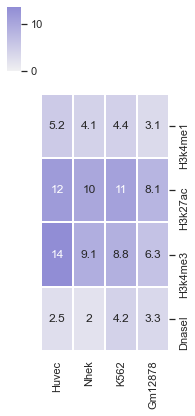

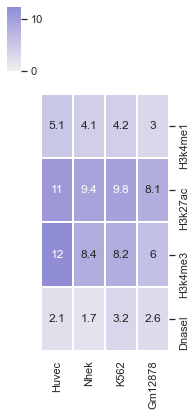

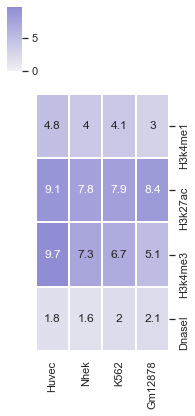

In [ ]:
for kmer in [11,12,13]:
    sub_dnase = dnase_all[dnase_all['kmer']==kmer]
    sub_dnase['Hist'] = "DnaseI"
    sub_dnase = sub_dnase.rename(columns={"Distance (bp)": "bins"})
    sub_dnase = sub_dnase.replace("DnaseI Density", "Density").replace("UwNhek", "Nhek").replace("UwGm12878", "Gm12878").replace("UwMcf7", "Mcf7").replace("UwHepg2", "Hepg2").replace("UwK562", "K562").replace("UwHuvec", "Huvec")
    combined_df = pd.concat([sub_dnase, all_df[all_df['kmer'] == kmer]])
    ## Convert to wide dataframe
    # cell_types = list(set(combined_df.Cell))
    cell_types=['Huvec','Nhek','K562','Gm12878']
    hist_types = list(set(combined_df.Hist))

    histone_df = pd.DataFrame(columns=cell_types, index=hist_types)
    for cell in cell_types:
        for hist in hist_types:
            subdf = combined_df[(combined_df['Hist'] == hist) & (combined_df['Cell'] == cell)& (combined_df['kmer'] == kmer)]
            max_density = subdf.value.max()
            # print(cell, hist, max_density)
            histone_df.loc[hist, cell] = max_density
    histone_df = histone_df.astype(float)

    ### Plot wide dataframe to clustermap 
    kws = dict(cbar_kws=dict(orientation='vertical'), figsize=(3, 6))

    g = sns.clustermap(
        histone_df,
        annot=histone_df,
        row_cluster=False,
        col_cluster=False,
        dendrogram_ratio=(.1, .2), linewidth=0.1,
        # cbar_pos=(0, 0, .03, .4),
        vmin = 0,
        #vmax=0.5,
        mask=histone_df.isnull(),
        metric="canberra",
        cmap=sns.color_palette("light:#918DD5", as_cmap=True),
        **kws,
        # cbar_kws={"ticks":[0, 0.1, 0.2, 0.3]}
    )

    # x0, _y0, _w, _h = g.cbar_pos
    # g.ax_cbar.set_position([0.085, -0.1, g.ax_row_dendrogram.get_position().width+0.2, 0.05])
    # g.ax_cbar.set_position([x0, 0.9, g.ax_row_dendrogram.get_position().width+0.2, 0.05])
    # g.ax_cbar.set_title("Density")
    # g.ax_cbar.tick_params(axis='x', length=5)

    plt.tight_layout()
    # plt.title(f"k{kmer}")
    plt.savefig(f"figs/histones/heatmap_k{kmer}.svg", transparent=True)
    plt.savefig(f"figs/histones/heatmap_k{kmer}.png", transparent=True)
    plt.show()
    plt.close()

### COPY TO FINAL

In [ ]:
cell_lines = ['Nhlf', 'Huvec', 'K562', 'Nhek', 'H1hesc', 'Gm12878', 'Hsmm']
hist_mods = ['H3k27ac', 'H3k4me3', 'H3k4me1']
analysis="histones"

for kmer in [11,12,13]:
    for cell in cell_lines:
        for hist in hist_mods:
            numfile = f"{analysis}/mutations_{kmer}bp_nulls.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.out.num"
            sumfile = f"{analysis}/mutations_{kmer}bp_nulls.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.out.sum"
            for fn in [numfile, sumfile]:
                destination_path = f"FINAL/{fn}"
                # Create the destination directory if it doesn't exist
                destination_directory = os.path.dirname(destination_path)
                if not os.path.exists(destination_directory):
                    os.makedirs(destination_directory)            
                # print(destination_path)
                shutil.copy2(fn, destination_path)

### Plot Ins/Dels/Subs DONE

In [ ]:
kmer=13

muts = ['ins', 'subs', 'dels']
cell_lines = ['Nhlf', 'Huvec', 'K562', 'Nhek', 'H1hesc', 'Gm12878', 'Hsmm']
hist_mods = ['H3k27ac', 'H3k4me3', 'H3k4me1']

all_df = pd.DataFrame()
for hist in hist_mods:
    for cell in cell_lines: 
        for mut in muts:
            numfile = f"histones/mutations_{kmer}bp_nulls_{mut}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.out.num"
            sumfile = f"histones/mutations_{kmer}bp_nulls_{mut}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.out.sum"
            ### Build num dictionary
            numD = numsumfile_reader(numfile)
            ### Build sum dictionary
            sumD = numsumfile_reader(sumfile)
            bins = numD.keys()
            assert numD != sumD, "Num and Sum are same"
            combined = {}
            for k,v in numD.items(): #k is the bin number, v is the num Score
                score = (sumD[k])/v # sum Score / num Score
                combined[k] = score     
            data=pd.DataFrame({"bins":bins, "Density":list(combined.values()), "Cell":cell, "Hist":hist, "Mut":mut})
            melted = pd.melt(data, id_vars=['bins', 'Cell', 'Hist', 'Mut'], value_vars=['Density'])
            all_df = pd.concat([all_df,melted])
    all_df = all_df.reset_index(drop=True)
all_df.head(3)

,bins,Cell,Hist,Mut,variable,value
0,-1000,Nhlf,H3k27ac,ins,Density,4.423304
1,-999,Nhlf,H3k27ac,ins,Density,4.424616
2,-998,Nhlf,H3k27ac,ins,Density,4.426450


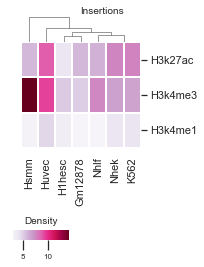

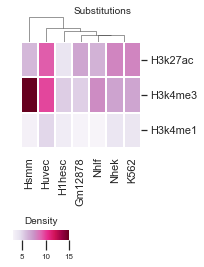

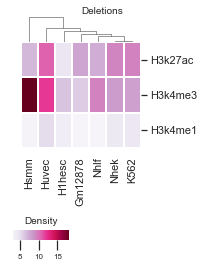

In [ ]:
cell_types = list(set(all_df.Cell))
hist_types = list(set(all_df.Hist))

mut2title = {"ins":"Insertions", "dels":"Deletions", "subs":"Substitutions"}

sns.set(style="whitegrid", 
rc={'figure.figsize':(3,5), 
    "axes.spines.right": False, 
    "axes.spines.top": False, 
    'font.size': 12})

for mut in muts:
    histone_df = pd.DataFrame(columns=cell_types, index=hist_types)
    for cell in cell_types:
        for hist in hist_types:
            # subdf = all_df[all_df['Hist'] == hist & all_df['Cell'] == cell]
            subdf = all_df[(all_df['Hist'] == hist) & (all_df['Cell'] == cell) & (all_df['Mut'] == mut)]
            max_density = subdf.value.max()
            # print(cell, hist, max_density)
            histone_df.loc[hist, cell] = max_density
    histone_df = histone_df.astype(float) 
    histone_df
    # kws = dict(cbar_kws=dict(ticks=[0, 0.1, 0.2, 0.3], orientation='horizontal'), figsize=(7, 5))
    kws = dict(cbar_kws=dict(orientation='horizontal'), figsize=(3, 3))

    g = sns.clustermap(
        histone_df,
        row_cluster=False,
        col_cluster=True,
        dendrogram_ratio=(.1, .2), linewidth=0.1,
        # cbar_pos=(0, 0, .03, .4),
        # vmin = 0, vmax=0.5,
        cmap="PuRd",
        **kws,
        annot_kws={"size": 8}
        # cbar_kws={"ticks":[0, 0.1, 0.2, 0.3]}
    )
    g.fig.suptitle(mut2title[mut], fontsize=10)
    x0, _y0, _w, _h = g.cbar_pos
    g.ax_cbar.set_position([0.085, -0.1, g.ax_row_dendrogram.get_position().width+0.2, 0.05])
    # g.ax_cbar.set_position([x0, 0.9, g.ax_row_dendrogram.get_position().width+0.2, 0.05])
    g.ax_cbar.set_title('Density', fontsize=10)
    g.ax_cbar.tick_params(axis='x', length=10, labelsize=8)
    plt.savefig(f"figs/histones/heatmap_{mut}_k{kmer}.svg", transparent=True)
    plt.show()
    plt.close()

#### Plot for 11/12/13 DONE

In [ ]:
custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False, 
                 'figure.figsize':(3,3)}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_style("whitegrid")

muts = ['ins', 'subs', 'dels']

all_df = pd.DataFrame()

for kmer in [11, 12, 13]:
    for hist in hist_mods:
        for cell in cell_lines: 
            for mut in muts:
                numfile = f"histones/mutations_{kmer}bp_nulls_{mut}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.out.num"
                sumfile = f"histones/mutations_{kmer}bp_nulls_{mut}.bed.score.wgEncodeBroadHistone{cell}{hist}StdSig.bedGraph.list.out.sum"
                # print(numfile, sumfile)
                ### Build num dictionary
                numD = numsumfile_reader(numfile)
                ### Build sum dictionary
                sumD = numsumfile_reader(sumfile)
                bins = numD.keys()
                assert numD != sumD, "Num and Sum are same"
                combined = {}
                for k,v in numD.items(): #k is the bin number, v is the num Score
                    score = (sumD[k])/v # sum Score / num Score
                    combined[k] = score     
                data=pd.DataFrame({"bins":bins, "Density":list(combined.values()), "Cell":cell, "Hist":hist, "Mut":mut, "kmer":kmer})
                melted = pd.melt(data, id_vars=['bins', 'Cell', 'Hist', 'Mut','kmer'], value_vars=['Density'])
                all_df = pd.concat([all_df,melted])
all_df = all_df.reset_index(drop=True)
all_df.head(3)

,bins,Cell,Hist,Mut,kmer,variable,value
0,-1000,Nhlf,H3k27ac,ins,11,Density,4.898829
1,-999,Nhlf,H3k27ac,ins,11,Density,4.915919
2,-998,Nhlf,H3k27ac,ins,11,Density,4.935528


In [ ]:
cell_types = list(set(all_df.Cell))
hist_types = list(set(all_df.Hist))
for kmer in [11,12,13]:
    for mut in muts:
        histone_df = pd.DataFrame(columns=cell_types, index=hist_types)
        for cell in cell_types:
            for hist in hist_types:
                subdf = all_df[(all_df['Hist'] == hist) & (all_df['Cell'] == cell) & (all_df['Mut'] == mut) & (all_df['kmer'] == kmer)]
                max_density = subdf.value.max()
                # print(cell, hist, max_density)
                histone_df.loc[hist, cell] = max_density
        histone_df = histone_df.astype(float) 
        histone_df
        # kws = dict(cbar_kws=dict(ticks=[0, 0.1, 0.2, 0.3], orientation='horizontal'), figsize=(7, 5))
        kws = dict(cbar_kws=dict(orientation='horizontal'), figsize=(3, 3))

        g = sns.clustermap(
            histone_df,
            row_cluster=False,
            col_cluster=True,
            dendrogram_ratio=(.1, .2), linewidth=0.1,
            # cbar_pos=(0, 0, .03, .4),
            # vmin = 0, vmax=0.5,
            cmap="PuRd",
            **kws,
            # cbar_kws={"ticks":[0, 0.1, 0.2, 0.3]}
        )
        g.fig.suptitle(mut.upper())
        x0, _y0, _w, _h = g.cbar_pos
        g.ax_cbar.set_position([0.085, -0.1, g.ax_row_dendrogram.get_position().width+0.2, 0.05])
        # g.ax_cbar.set_position([x0, 0.9, g.ax_row_dendrogram.get_position().width+0.2, 0.05])
        g.ax_cbar.set_title('Density')
        g.ax_cbar.tick_params(axis='x', length=10)
        plt.show()
        plt.close()